In [254]:
import networkx as nx
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import pickle

import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis import contacts
from MDAnalysis.analysis import rms
from MDAnalysis.analysis import dihedrals
from MDAnalysis.analysis import psa

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

In [255]:
plt.rcParams["font.family"] = "Times"
plt.rcParams['mathtext.fontset'] = 'cm'

In [256]:
import os
import sys
import glob
import pathlib
from scipy import spatial

In [257]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
sys_up = '../sys_up'
sys_down = '../sys_down'

gly2_d2u = '../2-head_pro_gly_tmd_d2u'
gly2_u2d = '../2-head_pro_gly_tmd_u2d'
gly3_d2u = '../3-head_pro_gly_tmd_d2u'
gly3_u2d = '../3-head_pro_gly_tmd_u2d'
gly4_d2u = '../4-head_pro_gly_tmd_d2u'
gly4_u2d = '../4-head_pro_gly_tmd_u2d'
gly5_d2u = '../5-head_pro_gly_tmd_d2u'
gly5_u2d = '../5-head_pro_gly_tmd_u2d'
gly6_d2u = '../6-head_pro_gly_tmd_d2u'
gly6_u2d = '../6-head_pro_gly_tmd_u2d'

nogly2_d2u = '../2-head_pro_nogly_tmd_d2u'
nogly2_u2d = '../2-head_pro_nogly_tmd_u2d'
nogly3_d2u = '../3-head_pro_nogly_tmd_d2u'
nogly3_u2d = '../3-head_pro_nogly_tmd_u2d'
nogly4_d2u = '../4-head_pro_nogly_tmd_d2u'
nogly4_u2d = '../4-head_pro_nogly_tmd_u2d'

equil_gly_down = '../0-tmdminequil_gly_down'
equil_gly_up = '../0-tmdminequil_gly_up'
equil_nogly_down = '../0-tmdminequil_nogly_down'
equil_nogly_up = '../0-tmdminequil_nogly_up'

In [6]:
def sel2phipsi(u, degree2radian=True, downsample=1):
    """MDAna selection u to phi and psi lists by segid
    NB: segid is sometimes chain in VMD"""
    segname_list = u.segments.segids.tolist()
    psi_list = []
    phi_list = []
    for seg in segname_list:
        # Chain information
        chain = u.select_atoms(f"protein and segid {seg}")
        # Phi and psi
        phi_sel, psi_sel, ind_phi, ind_psi = get_phipsi_sel(chain)
        phi_ang = get_dihe_ang(phi_sel, degree2radian, downsample=downsample)
        psi_ang = get_dihe_ang(psi_sel, degree2radian, downsample=downsample)
        # Append
        phi_list.append(phi_ang)
        psi_list.append(psi_ang)
    return phi_list, psi_list

def get_phipsi_sel(protein):
    # NB: to get a selection, e.g. protein = u.select_atoms("protein")
    phi_sel = [res.phi_selection() for res in protein.residues[:]]
    psi_sel = [res.psi_selection() for res in protein.residues[:]]
    # deal with None (edges)
    ind_phi, phi_sel = get_ind_none(phi_sel)
    ind_psi, psi_sel = get_ind_none(psi_sel)
    return phi_sel, psi_sel, ind_phi, ind_psi

def get_dihe_ang(phi_sel, degree2radian=True, downsample=1):
    """Get dihedral angles corresponding to selection (here phi)
    Input another dihedral selection (list) to get another angle."""
    phi_ang = mda.analysis.dihedrals.Dihedral(phi_sel).run(step=downsample).angles
    if degree2radian:
        phi_ang = phi_ang / 180 * np.pi
    return phi_ang

def get_ind_none(phi_sel):
    """Get indices in list that are none"""
    ind_none = []
    ind_not_none = []
    new_sel = []
    for i, sel in enumerate(phi_sel):
        if sel is None:
            ind_none.append(i)
        else:
            new_sel.append(sel)
            ind_not_none.append(i)
    return ind_not_none, new_sel


# ###################################################################
# From the circular analysis package
def get_angdiff(x, y):
    """Difference between angles x and y"""
    # NB: slightly slower but easier for me to read, possibly easier to dask-ify
    diff = np.arctan2(np.sin(x-y), np.cos(x-y))
    return diff

def circ_dist(x, y):
    # one option for distance in circular space
    diff = np.arctan2(np.sin(x-y), np.cos(x-y))  # must use circular distance
    dist = np.sqrt(np.sum(diff**2))
    return dist

def get_RMSA(traj, ref):
    """Root-mean-square angle
    Input:
        traj (Txm numpy array): dihedral angles from trajectory
        ref (length m numpy array): dihedral angles from reference structure
    Output:
        rmsa (length T numpy array): root-mean-square of dihedral angles
    """
    diff_dihe = get_angdiff(traj, ref)
    rmsa = np.sqrt(np.mean(diff_dihe**2, axis=1))
    return rmsa

In [7]:
def get_atom_position(U, sel="name CA"):
    '''
        Get atom position array in shape (n_frame, n_atoms, 3)
    '''
    ca = U.select_atoms(sel);
    P = np.array([ca.positions for _ in U.trajectory])
    return P

In [8]:
def get_res_dihedral(U, sel="protein", chain_id=0, downsample=1):
    '''
        Get residue dihedral array in shape (n_frame, n_phi_psi)
    '''
    phi, psi = sel2phipsi(U.select_atoms(sel), downsample=downsample)
    dihe_arr = np.column_stack((phi[chain_id], psi[chain_id]))
    return dihe_arr

In [9]:
def hausdorff_neighbors_RMSA(U1_dihe_arr, U2_dihe_arr, downsample=1000):
    
    r"""Find the Hausdorff neighbors of two paths.

    Parameters
    ----------
    U1_dihe_arr : numpy.ndarray
        phi and psi in the first path
    U2_dihe_arr : numpy.ndarray
        phi and psi in the second path

    Returns
    -------
    dict
        dictionary of two pairs of numpy arrays, the first pair (key
        "frames") containing the indices of (Hausdorff) nearest
        neighbors for `U1` and `U2`, respectively, the second (key
        "distances") containing (corresponding) nearest neighbor
        distances for `U1` and `U2`, respectively

    Notes
    -----
    - Hausdorff distance uses RMSA distance here, instead of the default RMSD distance.

    """
    
    # form #fr x #fr distance matrix (in radian)
    N = np.shape(U1_dihe_arr)[1] # total number of phi and psi
    dist = sp.spatial.distance.cdist(U1_dihe_arr[0::downsample, :], U2_dihe_arr[0::downsample, :], 
                                     metric=circ_dist)

    # form dic
    nearest_neighbors = {
        'frames' : (np.argmin(dist, axis=1), np.argmin(dist, axis=0)),
        'distances' : (np.amin(dist, axis=1)/N**0.5, np.amin(dist, axis=0)/N**0.5) #RMSA
    }
    
    return nearest_neighbors

In [10]:
def multi_traj_psa(diheset, downsample=1000, RMSA=True):
    
    # use diheset or position_set
    pair_info = {}
    hdist_mat = np.zeros([len(diheset), len(diheset)])

    for i in range(len(diheset)):
        for j in range(i+1, len(diheset)):
            if RMSA: # use RMSA distance
                psapair = hausdorff_neighbors_RMSA(diheset[i], diheset[j], downsample=downsample)
            else: # use default RMSD distance
                psapair = psa.hausdorff_neighbors(diheset[i], diheset[j])
            pair_info[f'({i},{j})'] = psapair
            hdist = np.max([psapair['distances'][0], psapair['distances'][1]]) 
            hdist_mat[i][j] = hdist
            hdist_mat[j][i] = hdist
            
    return hdist_mat, pair_info

In [11]:
def mat2tri(mat):
    # take only half of the symmetric matrix and exclude the diagonal terms by k=1
    ind_triu = np.triu_indices_from(mat, k=1)
    val = mat[ind_triu]
    return val

# Free equil data

## Glycan

- ## Down

In [75]:
downstruc = '6vxx_PROA'

Starting structure (wet)

In [77]:
gly_downpsf = f"{sys_down}/{downstruc}.psf"

In [36]:
gly2_downpdb = f"{equil_gly_down}/minequil_pt1/{downstruc}_eq2-all.pdb"
U_gly2_down = mda.Universe(gly_downpsf, gly2_downpdb)

gly3_downpdb = f"{equil_gly_down}/minequil_pt2/{downstruc}_eq3-all.pdb"
U_gly3_down = mda.Universe(gly_downpsf, gly3_downpdb)

gly4_downpdb = f"{equil_gly_down}/minequil_pt3/{downstruc}_eq4-all.pdb"
U_gly4_down = mda.Universe(gly_downpsf, gly4_downpdb)

gly5_downpdb = f"{equil_gly_down}/minequil_pt4/{downstruc}_eq5-all.pdb"
U_gly5_down = mda.Universe(gly_downpsf, gly5_downpdb)

gly6_downpdb = f"{equil_gly_down}/minequil_pt5/{downstruc}_eq6-all.pdb"
U_gly6_down = mda.Universe(gly_downpsf, gly6_downpdb)

In [37]:
Uset_gly_down_target = [U_gly2_down, U_gly3_down, U_gly4_down, U_gly5_down, U_gly6_down]

Crystal structure (wet)

In [78]:
gly_downpdb_crys = f"{sys_down}/{downstruc}.pdb"
U_gly_down_crys = mda.Universe(gly_downpsf, gly_downpdb_crys)

Equil dcd (dried)

In [39]:
gly_downpsf_dry = f"{sys_down}/{downstruc}-dry.psf"

gly_down_dry2 = f'{equil_gly_down}/minequil_pt1/pt2-dryunwrap.dcd'
gly_down_dry3 = f'{equil_gly_down}/minequil_pt1/pt3-dryunwrap.dcd'
gly_down_dry4 = f'{equil_gly_down}/minequil_pt1/pt4-dryunwrap.dcd'
gly_down_dry5 = f'{equil_gly_down}/minequil_pt1/pt5-dryunwrap.dcd'
gly_down_dry6 = f'{equil_gly_down}/minequil_pt1/pt6-dryunwrap.dcd'
gly_down_dry7 = f'{equil_gly_down}/minequil_pt2/npt1-dryunwrap.dcd'
gly_down_dry8 = f'{equil_gly_down}/minequil_pt2/npt2-dryunwrap.dcd'
gly_down_dry9 = f'{equil_gly_down}/minequil_pt3/pt1-dryunwrap.dcd'
gly_down_dry10 = f'{equil_gly_down}/minequil_pt3/pt2-dryunwrap.dcd'
gly_down_dry11 = f'{equil_gly_down}/minequil_pt4/pt1-dryunwrap.dcd'
gly_down_dry12 = f'{equil_gly_down}/minequil_pt4/pt2-dryunwrap.dcd'
gly_down_dry13 = f'{equil_gly_down}/minequil_pt5/pt1-dryunwrap.dcd'
gly_down_dry14 = f'{equil_gly_down}/minequil_pt5/pt2-dryunwrap.dcd'
gly_down_dry15 = f'{equil_gly_down}/minequil_pt5/pt3-dryunwrap.dcd'
gly_down_dry16 = f'{equil_gly_down}/minequil_pt6/pt1-dryunwrap.dcd'
gly_down_dry17 = f'{equil_gly_down}/minequil_pt6/pt2-dryunwrap.dcd'
gly_down_dry18 = f'{equil_gly_down}/minequil_pt7/pt1-dryunwrap.dcd'
gly_down_dry19 = f'{equil_gly_down}/minequil_pt7/pt2-dryunwrap.dcd'

In [40]:
U_gly_equildown_dry = mda.Universe(gly_downpsf_dry, 
                                   [gly_down_dry2, gly_down_dry3, gly_down_dry4, gly_down_dry5, gly_down_dry6,
                                   gly_down_dry7, gly_down_dry8, gly_down_dry9, gly_down_dry10, gly_down_dry11,
                                   gly_down_dry12, gly_down_dry13, gly_down_dry14, gly_down_dry15, gly_down_dry16,
                                   gly_down_dry17, gly_down_dry18, gly_down_dry19])

- ## Up

Starting structure (wet)

In [79]:
upstruc = '6vsb_UPprotomer'

In [80]:
gly_uppsf = f"{sys_up}/{upstruc}.psf"

In [42]:
gly2_uppdb = f"{equil_gly_up}/minequil_pt1/{upstruc}_eq2-all.pdb"
U_gly2_up = mda.Universe(gly_uppsf, gly2_uppdb)

gly3_uppdb = f"{equil_gly_up}/minequil_pt2/{upstruc}_eq3-all.pdb"
U_gly3_up = mda.Universe(gly_uppsf, gly3_uppdb)

gly4_uppdb = f"{equil_gly_up}/minequil_pt3/{upstruc}_eq4-all.pdb"
U_gly4_up = mda.Universe(gly_uppsf, gly4_uppdb)

gly5_uppdb = f"{equil_gly_up}/minequil_pt4/{upstruc}_eq5-all.pdb"
U_gly5_up = mda.Universe(gly_uppsf, gly5_uppdb)

gly6_uppdb = f"{equil_gly_up}/minequil_pt5/{upstruc}_eq6-all.pdb"
U_gly6_up = mda.Universe(gly_uppsf, gly6_uppdb)

In [43]:
Uset_gly_up_target = [U_gly2_up, U_gly3_up, U_gly4_up, U_gly5_up, U_gly6_up]

Crystal structure (wet)

In [81]:
gly_uppdb_crys = f"{sys_up}/{upstruc}.pdb"

U_gly_up_crys = mda.Universe(gly_uppsf, gly_uppdb_crys)

Equil dcd (dried)

In [45]:
gly_uppsf_dry = f"{sys_up}/{upstruc}-dry.psf"

gly_up_dry2 = f'{equil_gly_up}/minequil_pt1/pt2-dryunwrap.dcd'
gly_up_dry3 = f'{equil_gly_up}/minequil_pt1/pt3-dryunwrap.dcd'
gly_up_dry4 = f'{equil_gly_up}/minequil_pt1/pt4-dryunwrap.dcd'
gly_up_dry5 = f'{equil_gly_up}/minequil_pt1/pt5-dryunwrap.dcd'
gly_up_dry6 = f'{equil_gly_up}/minequil_pt1/pt6-dryunwrap.dcd'
gly_up_dry7 = f'{equil_gly_up}/minequil_pt2/npt1-dryunwrap.dcd'
gly_up_dry8 = f'{equil_gly_up}/minequil_pt2/npt2-dryunwrap.dcd'
gly_up_dry9 = f'{equil_gly_up}/minequil_pt3/pt1-dryunwrap.dcd'
gly_up_dry10 = f'{equil_gly_up}/minequil_pt3/pt2-dryunwrap.dcd'
gly_up_dry11 = f'{equil_gly_up}/minequil_pt4/pt1-dryunwrap.dcd'
gly_up_dry12 = f'{equil_gly_up}/minequil_pt4/pt2-dryunwrap.dcd'
gly_up_dry13 = f'{equil_gly_up}/minequil_pt5/pt1-dryunwrap.dcd'
gly_up_dry14 = f'{equil_gly_up}/minequil_pt5/pt2-dryunwrap.dcd'
gly_up_dry15 = f'{equil_gly_up}/minequil_pt6/pt1-dryunwrap.dcd'
gly_up_dry16 = f'{equil_gly_up}/minequil_pt6/pt2-dryunwrap.dcd'
gly_up_dry17 = f'{equil_gly_up}/minequil_pt6/pt3-dryunwrap.dcd'
gly_up_dry18 = f'{equil_gly_up}/minequil_pt7/pt1-dryunwrap.dcd'
gly_up_dry19 = f'{equil_gly_up}/minequil_pt7/pt2-dryunwrap.dcd'

In [46]:
U_gly_equilup_dry = mda.Universe(gly_uppsf_dry, 
                                   [gly_up_dry2, gly_up_dry3, gly_up_dry4, gly_up_dry5, gly_up_dry6,
                                   gly_up_dry7, gly_up_dry8, gly_up_dry9, gly_up_dry10, gly_up_dry11,
                                   gly_up_dry12, gly_up_dry13, gly_up_dry14, gly_up_dry15, gly_up_dry16,
                                   gly_up_dry17, gly_up_dry18, gly_up_dry19])

## Non-Glycan

- ## Down

In [19]:
downstruc = '6vxx_PROA_nogly'

Starting structure (wet)

In [20]:
nogly_downpsf = f"{sys_down}/{downstruc}.psf"

In [21]:
nogly2_downpdb = f"{equil_nogly_down}/minequil_pt1/{downstruc}_eq2-all.pdb"

U_nogly2_down = mda.Universe(nogly_downpsf, nogly2_downpdb)

In [22]:
nogly3_downpdb = f"{equil_nogly_down}/minequil_pt2/{downstruc}_eq3-all.pdb"

U_nogly3_down = mda.Universe(nogly_downpsf, nogly3_downpdb)

In [23]:
nogly4_downpdb = f"{equil_nogly_down}/minequil_pt3/{downstruc}_eq4-all.pdb"

U_nogly4_down = mda.Universe(nogly_downpsf, nogly4_downpdb)

In [24]:
Uset_nogly_down_target = [U_nogly2_down, U_nogly3_down, U_nogly4_down]

Crystal structure (wet)

In [25]:
nogly_downpdb_crys = f"{sys_down}/{downstruc}.pdb"
U_nogly_down_crys = mda.Universe(nogly_downpsf, nogly_downpdb_crys)

Equil dcd (dried)

In [41]:
nogly_downpsf_dry = f"{sys_down}/{downstruc}-dry.psf"

nogly_down_dry2 = f'{equil_nogly_down}/minequil_pt1/pt2-dryunwrap.dcd'
nogly_down_dry3 = f'{equil_nogly_down}/minequil_pt1/pt3-dryunwrap.dcd'
nogly_down_dry4 = f'{equil_nogly_down}/minequil_pt1/pt4-dryunwrap.dcd'
nogly_down_dry5 = f'{equil_nogly_down}/minequil_pt1/pt5-dryunwrap.dcd'
nogly_down_dry6 = f'{equil_nogly_down}/minequil_pt1/pt6-dryunwrap.dcd'
nogly_down_dry7 = f'{equil_nogly_down}/minequil_pt1/pt7-dryunwrap.dcd'
nogly_down_dry8 = f'{equil_nogly_down}/minequil_pt1/pt8-dryunwrap.dcd'
nogly_down_dry9 = f'{equil_nogly_down}/minequil_pt2/npt1-dryunwrap.dcd'
nogly_down_dry10 = f'{equil_nogly_down}/minequil_pt2/npt2-dryunwrap.dcd'
nogly_down_dry11 = f'{equil_nogly_down}/minequil_pt3/npt1-dryunwrap.dcd'
nogly_down_dry12 = f'{equil_nogly_down}/minequil_pt3/npt2-dryunwrap.dcd'
nogly_down_dry13 = f'{equil_nogly_down}/minequil_pt4/npt1-dryunwrap.dcd'
nogly_down_dry14 = f'{equil_nogly_down}/minequil_pt4/npt2-dryunwrap.dcd'
nogly_down_dry15 = f'{equil_nogly_down}/minequil_pt5/npt1-dryunwrap.dcd'
nogly_down_dry16 = f'{equil_nogly_down}/minequil_pt5/npt2-dryunwrap.dcd'
nogly_down_dry17 = f'{equil_nogly_down}/minequil_pt6/npt1-dryunwrap.dcd'
nogly_down_dry18 = f'{equil_nogly_down}/minequil_pt6/npt2-dryunwrap.dcd'

In [42]:
U_nogly_equildown_dry = mda.Universe(nogly_downpsf_dry, 
                                   [nogly_down_dry2, nogly_down_dry3, nogly_down_dry4, nogly_down_dry5, 
                                    nogly_down_dry6,nogly_down_dry7, nogly_down_dry8, nogly_down_dry9, 
                                    nogly_down_dry10, nogly_down_dry11, nogly_down_dry12, nogly_down_dry13,
                                   nogly_down_dry14, nogly_down_dry15, nogly_down_dry16, nogly_down_dry17,
                                   nogly_down_dry18])

- ## Up

Starting structure (wet)

In [26]:
upstruc = '6vsb_UPprotomer_nogly'

In [27]:
nogly_uppsf = f"{sys_up}/{upstruc}.psf"

In [28]:
nogly2_uppdb = f"{equil_nogly_up}/minequil_pt1/{upstruc}_eq2-all.pdb"
U_nogly2_up = mda.Universe(nogly_uppsf, nogly2_uppdb)

In [29]:
nogly3_uppdb = f"{equil_nogly_up}/minequil_pt2/{upstruc}_eq3-all.pdb"
U_nogly3_up = mda.Universe(nogly_uppsf, nogly3_uppdb)

In [30]:
nogly4_uppdb = f"{equil_nogly_up}/minequil_pt3/{upstruc}_eq4-all.pdb"
U_nogly4_up = mda.Universe(nogly_uppsf, nogly4_uppdb)

In [31]:
Uset_nogly_up_target = [U_nogly2_up, U_nogly3_up, U_nogly4_up]

Crystal structure (wet)

In [32]:
nogly_uppdb_crys = f"{sys_up}/{upstruc}.pdb"
U_nogly_up_crys = mda.Universe(nogly_uppsf, nogly_uppdb_crys)

Equil dcd (dried)

In [50]:
nogly_uppsf_dry = f"{sys_up}/{upstruc}-dry.psf"

nogly_up_dry2 = f'{equil_nogly_up}/minequil_pt1/pt3-dryunwrap.dcd'
nogly_up_dry3 = f'{equil_nogly_up}/minequil_pt1/pt4-dryunwrap.dcd'
nogly_up_dry4 = f'{equil_nogly_up}/minequil_pt1/pt5-dryunwrap.dcd'
nogly_up_dry5 = f'{equil_nogly_up}/minequil_pt1/pt6-dryunwrap.dcd'
nogly_up_dry6 = f'{equil_nogly_up}/minequil_pt2/npt1-dryunwrap.dcd'
nogly_up_dry7 = f'{equil_nogly_up}/minequil_pt2/npt2-dryunwrap.dcd'
nogly_up_dry8 = f'{equil_nogly_up}/minequil_pt3/pt1-dryunwrap.dcd'
nogly_up_dry9 = f'{equil_nogly_up}/minequil_pt3/pt2-dryunwrap.dcd'
nogly_up_dry10 = f'{equil_nogly_up}/minequil_pt4/pt1-dryunwrap.dcd'
nogly_up_dry11 = f'{equil_nogly_up}/minequil_pt4/pt2-dryunwrap.dcd'
nogly_up_dry12 = f'{equil_nogly_up}/minequil_pt5/pt1-dryunwrap.dcd'
nogly_up_dry13 = f'{equil_nogly_up}/minequil_pt5/pt2-dryunwrap.dcd'
nogly_up_dry14 = f'{equil_nogly_up}/minequil_pt6/pt1-dryunwrap.dcd'
nogly_up_dry15 = f'{equil_nogly_up}/minequil_pt6/pt2-dryunwrap.dcd'

In [51]:
U_nogly_equilup_dry = mda.Universe(nogly_uppsf_dry, 
                                   [nogly_up_dry2, nogly_up_dry3, nogly_up_dry4, nogly_up_dry5, nogly_up_dry6,
                                   nogly_up_dry7, nogly_up_dry8, nogly_up_dry9, nogly_up_dry10,
                                   nogly_up_dry11, nogly_up_dry12, nogly_up_dry13, nogly_up_dry14, nogly_up_dry15])

In [1]:
Uset_free = [U_gly_equilup_dry, U_gly_equildown_dry, U_nogly_equilup_dry, U_nogly_equildown_dry]

# TMD data

- ## U2D

### Glycan

rep1 (20ns)

In [ ]:
k = 20000
v = 2

gly2_u2ddcd_20000 = f'{gly2_u2d}/k{k}_v{v}_pt1/k{k}_v{v}_pt1-dryunwrap.dcd'
U_gly2_u2d_20000 = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_20000])

# gly2_u2ddcd_20000down = f'{gly2_u2d}/k{k}_v{v}_pt1/u2d_dry_aligned2downCrysCA.dcd'
# U_gly2_u2d_20000down = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_20000down])

# gly2_u2ddcd_20000up = f'{gly2_u2d}/k{k}_v{v}_pt1/u2d_dry_aligned2upCrysCA.dcd'
# U_gly2_u2d_20000up = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_20000up])

In [49]:
# alignment = align.AlignTraj(U_gly2_u2d_20000, U_gly_up_crys, 
#                             filename=f'{gly2_u2d}/k{k}_v{v}_pt1/u2d_dry_aligned2upCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

In [ ]:
k = 40000
v = 4

gly2_u2ddcd_40000 = f'{gly2_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
U_gly2_u2d_40000 = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_40000])

# gly2_u2ddcd_40000down = f'{gly2_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd'
# U_gly2_u2d_40000down = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_40000down])

# gly2_u2ddcd_40000up = f'{gly2_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd'
# U_gly2_u2d_40000up = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_40000up])

In [129]:
# alignment = align.AlignTraj(U_gly2_u2d_40000, U_gly_down_crys, 
#                             filename=f'{gly2_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

In [130]:
# alignment = align.AlignTraj(U_gly2_u2d_40000, U_gly_up_crys, 
#                             filename=f'{gly2_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

In [ ]:
k = 80000
v = 4

gly2_u2ddcd_80000 = f'{gly2_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
U_gly2_u2d_80000 = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_80000])

# gly2_u2ddcd_80000down = f'{gly2_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd'
# U_gly2_u2d_80000down = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_80000down])

# gly2_u2ddcd_80000up = f'{gly2_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd'
# U_gly2_u2d_80000up = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_80000up])

In [131]:
# alignment = align.AlignTraj(U_gly2_u2d_80000, U_gly_down_crys, 
#                             filename=f'{gly2_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

In [132]:
# alignment = align.AlignTraj(U_gly2_u2d_80000, U_gly_up_crys, 
#                             filename=f'{gly2_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

rep2 (25ns)

In [ ]:
k = 20000
v = 4

gly3_u2ddcd_20000 = f'{gly3_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
U_gly3_u2d_20000 = mda.Universe(gly_uppsf_dry, [gly3_u2ddcd_20000])

# gly3_u2ddcd_20000down = f'{gly3_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd'
# U_gly3_u2d_20000down = mda.Universe(gly_uppsf_dry, [gly3_u2ddcd_20000down])

# gly3_u2ddcd_20000up = f'{gly3_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd'
# U_gly3_u2d_20000up = mda.Universe(gly_uppsf_dry, [gly3_u2ddcd_20000up])

In [56]:
# alignment = align.AlignTraj(U_gly3_u2d_20000, U_gly_down_crys, 
#                             filename=f'{gly3_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

In [134]:
# alignment = align.AlignTraj(U_gly3_u2d_20000, U_gly_up_crys, 
#                             filename=f'{gly3_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

rep3 (30ns)

In [ ]:
k = 20000
v = 4

gly4_u2ddcd_20000 = f'{gly4_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
U_gly4_u2d_20000 = mda.Universe(gly_uppsf_dry, [gly4_u2ddcd_20000])

# gly4_u2ddcd_20000down = f'{gly4_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd'
# U_gly4_u2d_20000down = mda.Universe(gly_uppsf_dry, [gly4_u2ddcd_20000down])

# gly4_u2ddcd_20000up = f'{gly4_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd'
# U_gly4_u2d_20000up = mda.Universe(gly_uppsf_dry, [gly4_u2ddcd_20000up])

In [135]:
# alignment = align.AlignTraj(U_gly4_u2d_20000, U_gly_down_crys, 
#                             filename=f'{gly4_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

In [136]:
# alignment = align.AlignTraj(U_gly4_u2d_20000, U_gly_up_crys, 
#                             filename=f'{gly4_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

rep4 (35ns)

In [ ]:
k = 20000
v = 4

gly5_u2ddcd_20000 = f'{gly5_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
U_gly5_u2d_20000 = mda.Universe(gly_uppsf_dry, [gly5_u2ddcd_20000])

# gly5_u2ddcd_20000down = f'{gly5_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd'
# U_gly5_u2d_20000down = mda.Universe(gly_uppsf_dry, [gly5_u2ddcd_20000down])

# gly5_u2ddcd_20000up = f'{gly5_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd'
# U_gly5_u2d_20000up = mda.Universe(gly_uppsf_dry, [gly5_u2ddcd_20000up])

In [137]:
# alignment = align.AlignTraj(U_gly5_u2d_20000, U_gly_down_crys, 
#                             filename=f'{gly5_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

In [138]:
# alignment = align.AlignTraj(U_gly5_u2d_20000, U_gly_up_crys, 
#                             filename=f'{gly5_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

rep5 (40ns)

In [ ]:
k = 20000
v = 4

gly6_u2ddcd_20000 = f'{gly6_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
U_gly6_u2d_20000 = mda.Universe(gly_uppsf_dry, [gly6_u2ddcd_20000])

# gly6_u2ddcd_20000down = f'{gly6_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd'
# U_gly6_u2d_20000down = mda.Universe(gly_uppsf_dry, [gly6_u2ddcd_20000down])

# gly6_u2ddcd_20000up = f'{gly6_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd'
# U_gly6_u2d_20000up = mda.Universe(gly_uppsf_dry, [gly6_u2ddcd_20000up])

In [139]:
# alignment = align.AlignTraj(U_gly6_u2d_20000, U_gly_down_crys, 
#                             filename=f'{gly6_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

In [140]:
# alignment = align.AlignTraj(U_gly6_u2d_20000, U_gly_up_crys, 
#                             filename=f'{gly6_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

In [ ]:
Uset_gly_u2d = [U_gly2_u2d_80000, U_gly2_u2d_40000, U_gly2_u2d_20000, 
        U_gly3_u2d_20000, U_gly4_u2d_20000, U_gly5_u2d_20000, U_gly6_u2d_20000]

### Nogly

rep1 (20ns)

In [61]:
k = 20000
v = 4

nogly2_u2ddcd_20000 = f'{nogly2_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
U_nogly2_u2d_20000 = mda.Universe(nogly_uppsf_dry, [nogly2_u2ddcd_20000])

nogly2_u2ddcd_20000down = f'{nogly2_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd'
U_nogly2_u2d_20000down = mda.Universe(nogly_uppsf_dry, [nogly2_u2ddcd_20000down])

nogly2_u2ddcd_20000up = f'{nogly2_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd'
U_nogly2_u2d_20000up = mda.Universe(nogly_uppsf_dry, [nogly2_u2ddcd_20000up])

In [787]:
# alignment = align.AlignTraj(U_nogly2_u2d_20000, U_nogly_down_crys, 
#                             filename=f'{nogly2_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

In [788]:
# alignment = align.AlignTraj(U_nogly2_u2d_20000, U_nogly_up_crys, 
#                             filename=f'{nogly2_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2upCrysCA.dcd', 
#                             select="protein and name CA",)
# alignment.run()

rep2 (25ns)

In [62]:
k = 20000
v = 4
nogly3_u2ddcd_20000 = f'{nogly3_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
U_nogly3_u2d_20000 = mda.Universe(nogly_uppsf_dry, [nogly3_u2ddcd_20000])

rep3 (30ns)

In [63]:
k = 20000
v = 4
nogly4_u2ddcd_20000 = f'{nogly4_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
U_nogly4_u2d_20000 = mda.Universe(nogly_uppsf_dry, [nogly4_u2ddcd_20000])

In [93]:
Uset_nogly_u2d = [U_nogly2_u2d_20000, U_nogly3_u2d_20000, U_nogly4_u2d_20000]

- ## D2U

### Glycan

rep1 (20ns)

In [ ]:
k = 20000
v = 4

gly2_d2udcd_1 = f'{gly2_d2u}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
gly2_d2udcd_2 = f'{gly2_d2u}/k{k}_{v}ns_pt2/k{k}_{v}ns_pt2-dryunwrap.dcd'
U_gly2_d2u_20000 = mda.Universe(gly_downpsf_dry, [gly2_d2udcd_1, gly2_d2udcd_2])

rep2 (25ns)

In [ ]:
k = 20000
v = 4

gly3_d2udcd_1 = f'{gly3_d2u}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
gly3_d2udcd_2 = f'{gly3_d2u}/k{k}_{v}ns_pt2/k{k}_{v}ns_pt2-dryunwrap.dcd'
U_gly3_d2u_20000 = mda.Universe(gly_downpsf_dry, [gly3_d2udcd_1, gly3_d2udcd_2])

rep3 (30ns)

In [ ]:
k = 20000
v = 4

gly4_d2udcd_1 = f'{gly4_d2u}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
gly4_d2udcd_2 = f'{gly4_d2u}/k{k}_{v}ns_pt2/k{k}_{v}ns_pt2-dryunwrap.dcd'
gly4_d2udcd_3 = f'{gly4_d2u}/k{k}_{v}ns_pt3/k{k}_{v}ns_pt3-dryunwrap.dcd'
U_gly4_d2u_20000 = mda.Universe(gly_downpsf_dry, [gly4_d2udcd_1, gly4_d2udcd_2, gly4_d2udcd_3])

rep4 (35ns)

In [ ]:
k = 20000
v = 4

gly5_d2udcd_1 = f'{gly5_d2u}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
gly5_d2udcd_2 = f'{gly5_d2u}/k{k}_{v}ns_pt2/k{k}_{v}ns_pt2-dryunwrap.dcd'
gly5_d2udcd_3 = f'{gly5_d2u}/k{k}_{v}ns_pt3/k{k}_{v}ns_pt3-dryunwrap.dcd'
U_gly5_d2u_20000 = mda.Universe(gly_downpsf_dry, [gly5_d2udcd_1, gly5_d2udcd_2, gly5_d2udcd_3])

rep5 (40ns)

In [ ]:
k = 20000
v = 4

gly6_d2udcd_1 = f'{gly6_d2u}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
gly6_d2udcd_2 = f'{gly6_d2u}/k{k}_{v}ns_pt2/k{k}_{v}ns_pt2-dryunwrap.dcd'
U_gly6_d2u_20000 = mda.Universe(gly_downpsf_dry, [gly6_d2udcd_1, gly6_d2udcd_2])

In [ ]:
Uset_gly_d2u = [U_gly2_d2u_20000, U_gly3_d2u_20000, U_gly4_d2u_20000, U_gly5_d2u_20000, U_gly6_d2u_20000]

### Nogly

rep1 (20ns)

In [90]:
k = 20000
v = 4

nogly2_d2udcd_1 = f'{nogly2_d2u}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
nogly2_d2udcd_2 = f'{nogly2_d2u}/k{k}_{v}ns_pt2/k{k}_{v}ns_pt2-dryunwrap.dcd'
nogly2_d2udcd_3 = f'{nogly2_d2u}/k{k}_{v}ns_pt3/k{k}_{v}ns_pt3-dryunwrap.dcd'
U_nogly2_d2u_20000 = mda.Universe(nogly_downpsf_dry, [nogly2_d2udcd_1, nogly2_d2udcd_2, nogly2_d2udcd_3])

rep2 (25ns)

In [71]:
k = 20000
v = 4

nogly3_d2udcd_1 = f'{nogly3_d2u}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
nogly3_d2udcd_2 = f'{nogly3_d2u}/k{k}_{v}ns_pt2/k{k}_{v}ns_pt2-dryunwrap.dcd'
nogly3_d2udcd_3 = f'{nogly3_d2u}/k{k}_{v}ns_pt3/k{k}_{v}ns_pt3-dryunwrap.dcd'
U_nogly3_d2u_20000 = mda.Universe(nogly_downpsf_dry, [nogly3_d2udcd_1, nogly3_d2udcd_2, nogly3_d2udcd_3])

rep3 (30ns)

In [72]:
k = 20000
v = 4

nogly4_d2udcd_1 = f'{nogly4_d2u}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
nogly4_d2udcd_2 = f'{nogly4_d2u}/k{k}_{v}ns_pt2/k{k}_{v}ns_pt2-dryunwrap.dcd'
nogly4_d2udcd_3 = f'{nogly4_d2u}/k{k}_{v}ns_pt3/k{k}_{v}ns_pt3-dryunwrap.dcd'
U_nogly4_d2u_20000 = mda.Universe(nogly_downpsf_dry, [nogly4_d2udcd_1, nogly4_d2udcd_2, nogly4_d2udcd_3])

In [92]:
Uset_nogly_d2u = [U_nogly2_d2u_20000, U_nogly3_d2u_20000, U_nogly4_d2u_20000]

## NCA

In [15]:
def get_contact_q1q2(U, q1ref, q2ref, sel='name CA', step=10, radius=8.0, pbc=False):
    '''
    PSA paper: define a contact to be a residue pair whose Cα atoms are separated by a distance smaller than 8 Å.
    
    select (tuple(string, string)) – two contacting groups that change over time
    refgroup (tuple(AtomGroup, AtomGroup)) – two contacting atomgroups in their reference conformation.
                                    This can also be a list of tuples containing different atom groups  
    '''

    q1 = contacts.Contacts(U, select=(sel, sel),
                        refgroup=(q1ref, q1ref), radius=radius, method='radius_cut', pbc=pbc)
    q1.run(step=step)
    q2 = contacts.Contacts(U, step=step, select=(sel, sel),
                        refgroup=(q2ref, q2ref), radius=radius, method='radius_cut', pbc=pbc)
    q2.run(step=step)
    temp = np.vstack([q1.timeseries[:,1], q2.timeseries[:,1]]).T
    return temp

- ###  `v1` - compare with 6vxx and 6vsb PROA

Initial native contact of 6vxx_PROA and 6vsb_Upprotomer

In [30]:
ca_6vxx = U_gly_down_crys.select_atoms('name CA')
ca_6vsb = U_gly_up_crys.select_atoms('name CA')

Free equil

In [160]:
contactv1_set_free = []

In [161]:
for u in Uset_free:
    temp = get_contact_q1q2(u, ca_6vxx, ca_6vsb, sel='name CA', step=10, radius=8.0)
    contactv1_set_free.append(temp)

U2D

In [428]:
contactv1_set_gly_u2d = []

In [429]:
for u in Uset_gly_u2d:
    temp = get_contact_q1q2(u, ca_6vxx, ca_6vsb, sel='name CA', step=1, radius=8.0)
    contactv1_set_gly_u2d.append(temp)

In [108]:
contactv1_set_nogly_u2d = []

In [109]:
for u in Uset_nogly_u2d:
    temp = get_contact_q1q2(u, ca_6vxx, ca_6vsb, sel='name CA', step=1, radius=8.0)
    contactv1_set_nogly_u2d.append(temp)

D2U

In [432]:
contactv1_set_gly_d2u = []

In [433]:
for u in Uset_gly_d2u:
    temp = get_contact_q1q2(u, ca_6vxx, ca_6vsb, sel='name CA', step=1, radius=8.0)
    contactv1_set_gly_d2u.append(temp)

In [110]:
contactv1_set_nogly_d2u = []

In [111]:
for u in Uset_nogly_d2u:
    temp = get_contact_q1q2(u, ca_6vxx, ca_6vsb, sel='name CA', step=1, radius=8.0)
    contactv1_set_nogly_d2u.append(temp)

Save data.

In [112]:
# v1_dic = {}
# v1_dic['contactv1_set_free'] = contactv1_set_free
# v1_dic['contactv1_set_gly_u2d(7)'] = contactv1_set_gly_u2d
# v1_dic['contactv1_set_nogly_u2d(3)'] = contactv1_set_nogly_u2d
# v1_dic['contactv1_set_gly_d2u(5)'] = contactv1_set_gly_d2u
# v1_dic['contactv1_set_nogly_d2u(3)'] = contactv1_set_nogly_d2u

In [113]:
# with open(f'saved_pkl/v1_dic_NCA_crys_s1.pkl', 'wb') as f:
#     pickle.dump(v1_dic, f)

In [16]:
with open(f'saved_pkl/v1_dic_NCA_crys_s1.pkl', 'rb') as f:
    v1_dic = pickle.load(f)

In [17]:
contactv1_set_free = v1_dic['contactv1_set_free']
contactv1_set_gly_u2d = v1_dic['contactv1_set_gly_u2d(7)']
contactv1_set_nogly_u2d = v1_dic['contactv1_set_nogly_u2d(3)']
contactv1_set_gly_d2u = v1_dic['contactv1_set_gly_d2u(5)']
contactv1_set_nogly_d2u = v1_dic['contactv1_set_nogly_d2u(3)'] 

<IPython.core.display.Javascript object>


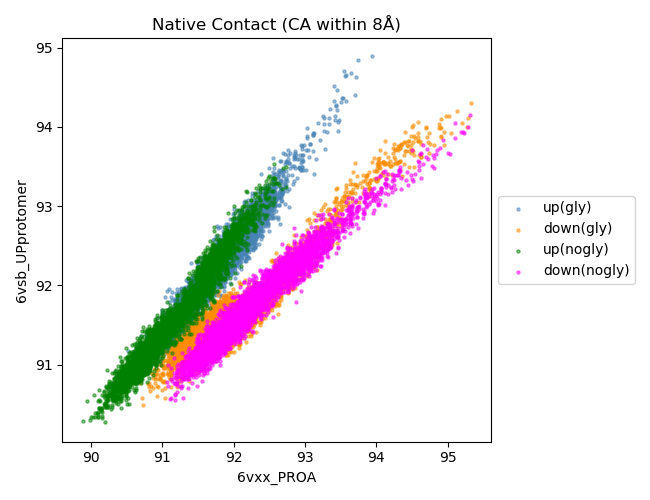

In [33]:
fig = plt.figure(figsize=[6.5,5])
ax = fig.add_subplot(111)

plt.scatter(contactv1_set_free[0][1:,0]*100, contactv1_set_free[0][1:,1]*100, s=5, alpha=0.5, 
            color='steelblue', label='up(gly)')
plt.scatter(contactv1_set_free[1][1:,0]*100, contactv1_set_free[1][1:,1]*100, s=5, alpha=0.5, 
            color='darkorange', label='down(gly)')
plt.scatter(contactv1_set_free[2][1:,0]*100, contactv1_set_free[2][1:,1]*100, s=5, alpha=0.5, 
            color='green', label='up(nogly)')
plt.scatter(contactv1_set_free[3][1:,0]*100, contactv1_set_free[3][1:,1]*100, s=5, alpha=0.5, 
            color='magenta', label='down(nogly)')

# labels = ['rep1_k80000', 'rep1_k40000', 'rep1_k20000', 'rep2', 'rep3', 'rep4', 'rep5']
# ii = 0
# for item in contactv1_set_gly_u2d:
#     plt.scatter(item[:,0]*100, item[:,1]*100, s=5, label=labels[ii], alpha=0.5)
# #     plt.plot(item[:,0]*100, item[:,1]*100, label=labels[ii])
#     ii += 1

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.0, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.title('Native Contact (CA within 8Å)')
plt.xlabel('6vxx_PROA')
plt.ylabel('6vsb_UPprotomer')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


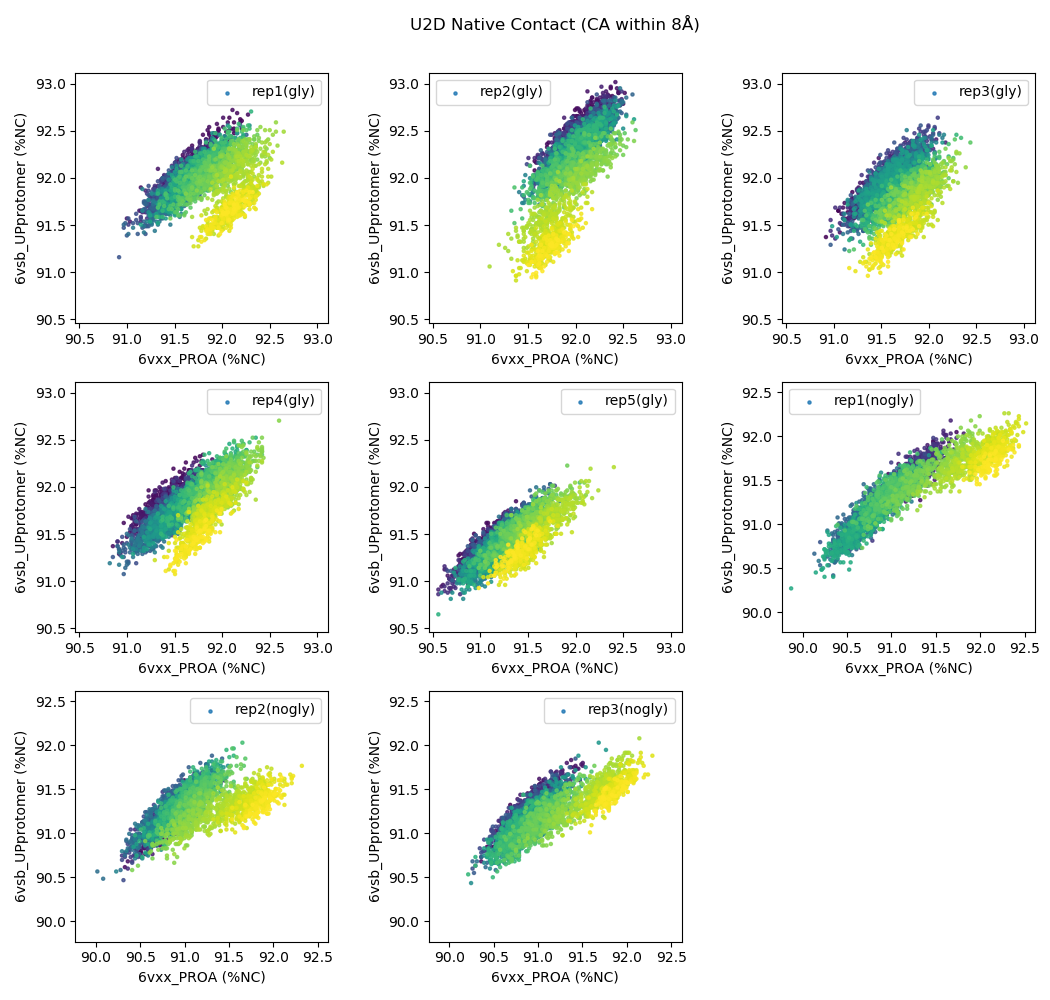

In [41]:
fig1 = plt.figure(figsize=[10.5, 10])
ax = [0, 0, 0, 0, 0, 0, 0, 0]

labels = ['rep1(gly)', 'rep2(gly)', 'rep3(gly)', 'rep4(gly)', 'rep5(gly)', 'rep1(nogly)', 'rep2(nogly)',
         'rep3(nogly)']
ii = 0
temp3 = np.max([np.max(x) for x in contactv1_set_gly_u2d[2:]])
temp4 = np.min([np.min(x) for x in contactv1_set_gly_u2d[2:]])
for item in contactv1_set_gly_u2d[2:]:
    ax[ii] = fig1.add_subplot(3,3,ii+1)
    plt.scatter(item[:,0]*100, item[:,1]*100, label=labels[ii], c=range(len(item[:,1])), s=5, alpha=0.8)
    plt.xlim(temp4*100-0.1, temp3*100+0.1)
    plt.ylim(temp4*100-0.1, temp3*100+0.1)
    plt.legend(loc='best')
    plt.xlabel('6vxx_PROA (%NC)')
    plt.ylabel('6vsb_UPprotomer (%NC)')
    ii += 1

ii = 0
temp3 = np.max([np.max(x) for x in contactv1_set_nogly_u2d])
temp4 = np.min([np.min(x) for x in contactv1_set_nogly_u2d])
for item in contactv1_set_nogly_u2d:
    ax[5+ii] = fig1.add_subplot(3, 3, ii+6)
    plt.scatter(item[:,0]*100, item[:,1]*100, label=labels[ii+5], c=range(len(item[:,1])), s=5, alpha=0.8)
    plt.xlim(temp4*100-0.1, temp3*100+0.1)
    plt.ylim(temp4*100-0.1, temp3*100+0.1)
    plt.legend(loc='best')
    plt.xlabel('6vxx_PROA (%NC)')
    plt.ylabel('6vsb_UPprotomer (%NC)')
    ii += 1

ax[1].set_title('U2D Native Contact (CA within 8Å)\n\n')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


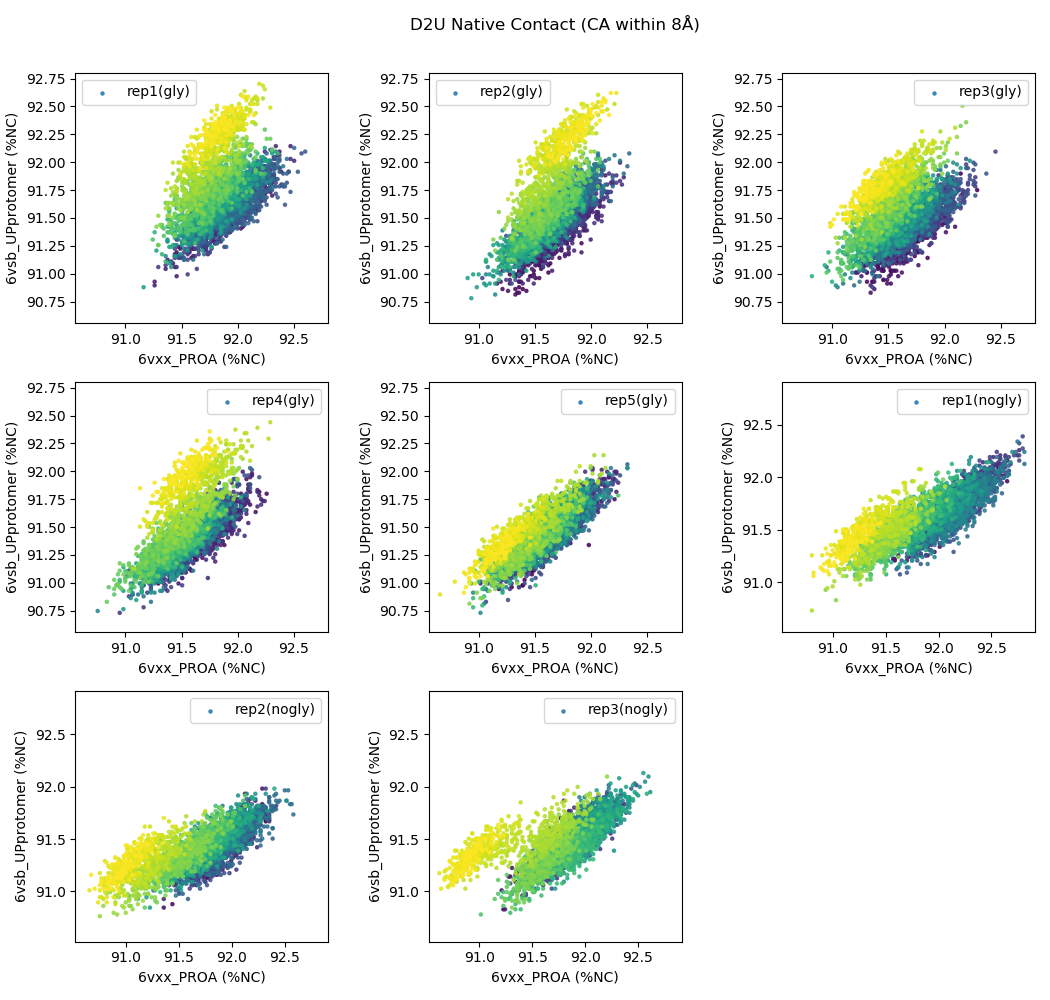

In [107]:
fig = plt.figure(figsize=[10.5, 10])
ax = [0, 0, 0, 0, 0, 0, 0, 0]

labels = ['rep1(gly)', 'rep2(gly)', 'rep3(gly)', 'rep4(gly)', 'rep5(gly)', 'rep1(nogly)', 'rep2(nogly)',
         'rep3(nogly)']
ii = 0
temp3 = np.max([np.max(x) for x in contactv1_set_gly_d2u])
temp4 = np.min([np.min(x) for x in contactv1_set_gly_d2u])
for item in contactv1_set_gly_d2u:
    ax[ii] = fig.add_subplot(3,3,ii+1)
    plt.scatter(item[:,0]*100, item[:,1]*100, label=labels[ii], c=range(len(item[:,1])), s=5, alpha=0.8)
    plt.xlim(temp4*100-0.1, temp3*100+0.1)
    plt.ylim(temp4*100-0.1, temp3*100+0.1)
    plt.legend(loc='best')
    plt.xlabel('6vxx_PROA (%NC)')
    plt.ylabel('6vsb_UPprotomer (%NC)')
    ii += 1

ii = 0
temp3 = np.max([np.max(x) for x in contactv1_set_nogly_d2u])
temp4 = np.min([np.min(x) for x in contactv1_set_nogly_d2u])
for item in contactv1_set_nogly_d2u:
    ax[5+ii] = fig.add_subplot(3, 3, ii+6)
    plt.scatter(item[:,0]*100, item[:,1]*100, label=labels[ii+5], c=range(len(item[:,1])), s=5, alpha=0.8)
    plt.xlim(temp4*100-0.1, temp3*100+0.1)
    plt.ylim(temp4*100-0.1, temp3*100+0.1)
    plt.legend(loc='best')
    plt.xlabel('6vxx_PROA (%NC)')
    plt.ylabel('6vsb_UPprotomer (%NC)')
    ii += 1

ax[1].set_title('D2U Native Contact (CA within 8Å)\n\n')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


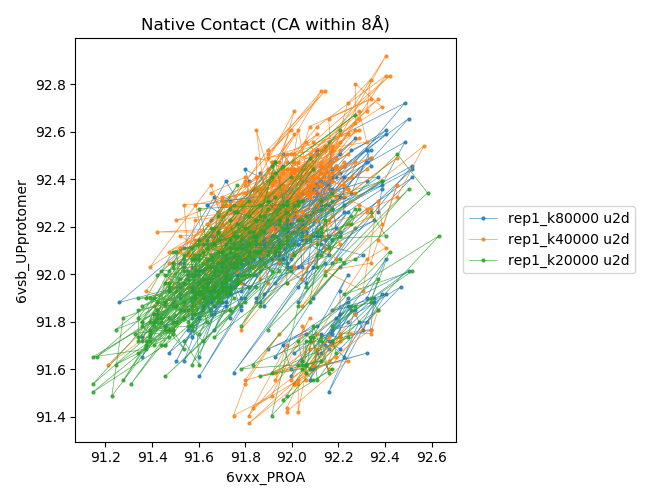

In [233]:
fig = plt.figure(figsize=[6.5,5])
ax = fig.add_subplot(111)

labels = ['rep1_k80000', 'rep1_k40000', 'rep1_k20000']
ii = 0
for item in contactv1_set_gly_u2d[:3]:
#     plt.scatter(item[:,0]*100, item[:,1]*100, s=5, label=labels[ii], alpha=0.5)
    plt.plot(item[:,0]*100, item[:,1]*100, marker='o', label=labels[ii]+' u2d', linewidth=0.5, markersize=2, alpha=0.8)
    ii += 1

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.0, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.title('Native Contact (CA within 8Å)')
plt.xlabel('6vxx_PROA')
plt.ylabel('6vsb_UPprotomer')

plt.tight_layout()
plt.show()

- ###  `v2` - compare with path specific starting and targeting structure

In [118]:
ca_gly_up_set = [u.select_atoms('name CA') for u in Uset_gly_up_target]
ca_gly_down_set = [u.select_atoms('name CA') for u in Uset_gly_down_target]
ca_nogly_up_set = [u.select_atoms('name CA') for u in Uset_nogly_up_target]
ca_nogly_down_set = [u.select_atoms('name CA') for u in Uset_nogly_down_target]

U2D

In [437]:
contactv2_set_gly_u2d = []

In [438]:
i = 0
for u in Uset_gly_u2d:
    if i<2:
        temp = get_contact_q1q2(u, ca_gly_down_set[0], ca_gly_up_set[0], sel='name CA', step=1, radius=8.0)
    else:
        temp = get_contact_q1q2(u, ca_gly_down_set[i-2], ca_gly_up_set[i-2], sel='name CA', step=1, radius=8.0)
    contactv2_set_gly_u2d.append(temp)
    i += 1

In [119]:
contactv2_set_nogly_u2d = []

In [120]:
i = 0
for u in Uset_nogly_u2d:
    temp = get_contact_q1q2(u, ca_nogly_down_set[i], ca_nogly_up_set[i], sel='name CA', step=1, radius=8.0)
    contactv2_set_nogly_u2d.append(temp)
    i += 1

D2U

In [441]:
contactv2_set_gly_d2u = []

In [442]:
i = 0
for u in Uset_gly_d2u:
    temp = get_contact_q1q2(u, ca_gly_down_set[i], ca_gly_up_set[i], sel='name CA', step=1, radius=8.0)
    contactv2_set_gly_d2u.append(temp)
    i += 1

In [121]:
contactv2_set_nogly_d2u = []

In [122]:
i = 0
for u in Uset_nogly_d2u:
    temp = get_contact_q1q2(u, ca_nogly_down_set[i], ca_nogly_up_set[i], sel='name CA', step=1, radius=8.0)
    contactv2_set_nogly_d2u.append(temp)
    i += 1

In [125]:
# v2_dic = {}
# v2_dic['contactv2_set_gly_u2d(7)'] = contactv2_set_gly_u2d
# v2_dic['contactv2_set_nogly_u2d(3)'] = contactv2_set_nogly_u2d
# v2_dic['contactv2_set_gly_d2u(5)'] = contactv2_set_gly_d2u
# v2_dic['contactv2_set_nogly_d2u(3)'] = contactv2_set_nogly_d2u

In [126]:
# with open(f'saved_pkl/v2_dic_NCA_target_s1.pkl', 'wb') as f:
#     pickle.dump(v2_dic, f)

In [18]:
with open(f'saved_pkl/v2_dic_NCA_target_s1.pkl', 'rb') as f:
    v2_dic = pickle.load(f)

In [19]:
contactv2_set_gly_u2d = v2_dic['contactv2_set_gly_u2d(7)'] 
contactv2_set_nogly_u2d = v2_dic['contactv2_set_nogly_u2d(3)']
contactv2_set_gly_d2u = v2_dic['contactv2_set_gly_d2u(5)']
contactv2_set_nogly_d2u = v2_dic['contactv2_set_nogly_d2u(3)']

<IPython.core.display.Javascript object>


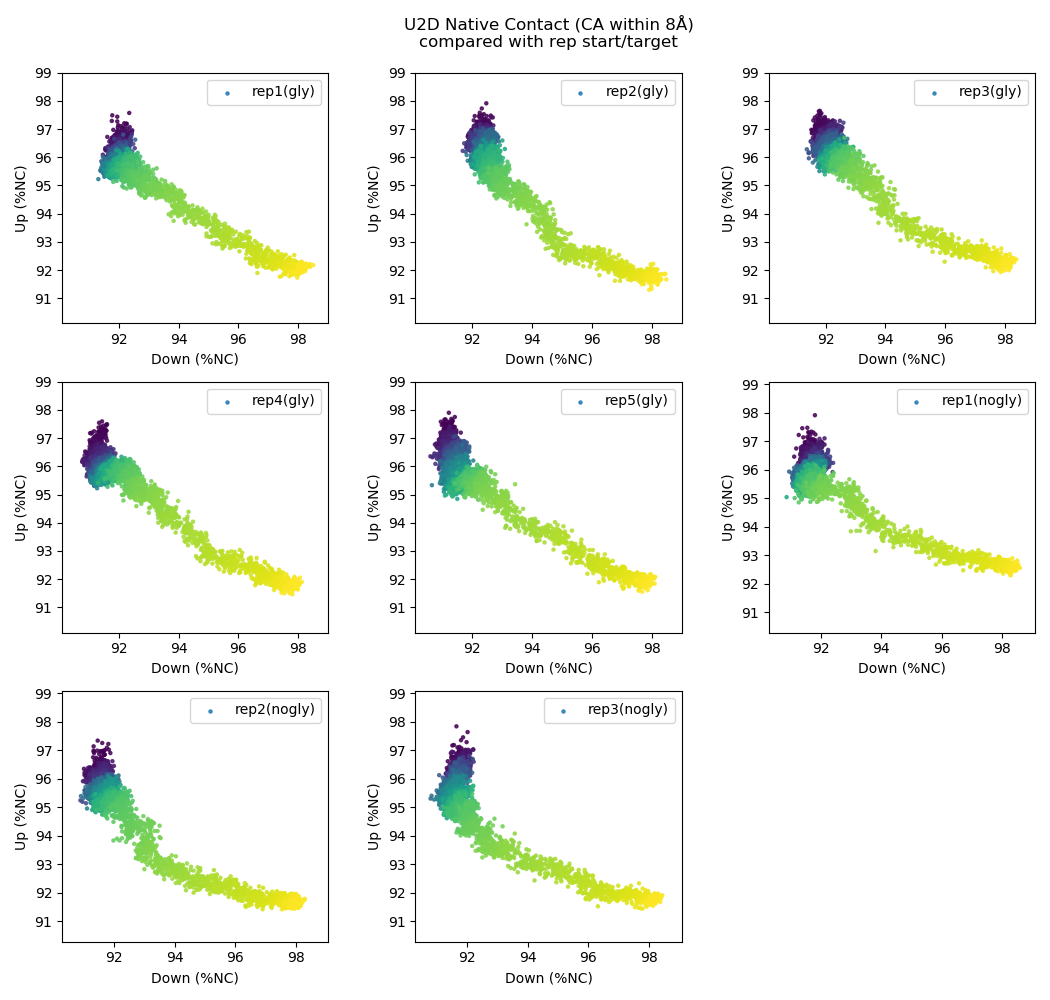

In [123]:
fig1 = plt.figure(figsize=[10.5, 10])
ax = [0, 0, 0, 0, 0, 0, 0, 0]

labels = ['rep1(gly)', 'rep2(gly)', 'rep3(gly)', 'rep4(gly)', 'rep5(gly)', 'rep1(nogly)', 'rep2(nogly)',
          'rep3(nogly)']
ii = 0
temp3 = np.max([np.max(x) for x in contactv2_set_gly_u2d[2:]])
temp4 = np.min([np.min(x) for x in contactv2_set_gly_u2d[2:]])
for item in contactv2_set_gly_u2d[2:]:
    ax[ii] = fig1.add_subplot(3,3,ii+1)
    plt.scatter(item[:,0]*100, item[:,1]*100, label=labels[ii], c=range(len(item[:,1])), s=5, alpha=0.8)
    plt.xlim(temp4*100-0.5, temp3*100+0.5)
    plt.ylim(temp4*100-0.5, temp3*100+0.5)
    plt.legend(loc='best')
    plt.xlabel('Down (%NC)')
    plt.ylabel('Up (%NC)')
    ii += 1

ii = 0
temp3 = np.max([np.max(x) for x in contactv2_set_nogly_u2d])
temp4 = np.min([np.min(x) for x in contactv2_set_nogly_u2d])
for item in contactv2_set_nogly_u2d:
    ax[5+ii] = fig1.add_subplot(3, 3, ii+6)
    plt.scatter(item[:,0]*100, item[:,1]*100, label=labels[ii+5], c=range(len(item[:,1])), s=5, alpha=0.8)
    plt.xlim(temp4*100-0.5, temp3*100+0.5)
    plt.ylim(temp4*100-0.5, temp3*100+0.5)
    plt.legend(loc='best')
    plt.xlabel('Down (%NC)')
    plt.ylabel('Up (%NC)')
    ii += 1

ax[1].set_title('U2D Native Contact (CA within 8Å)\ncompared with rep start/target\n')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


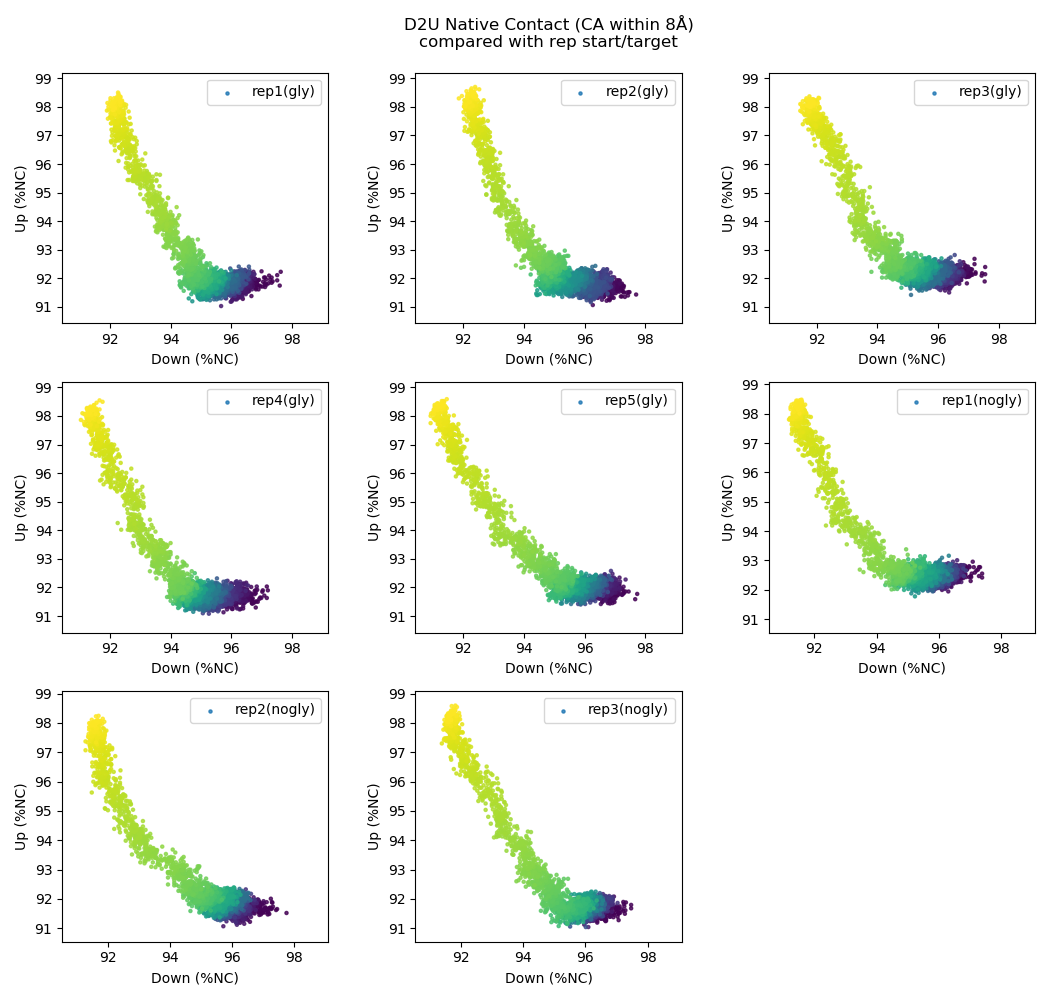

In [124]:
fig = plt.figure(figsize=[10.5, 10])
ax = [0, 0, 0, 0, 0, 0, 0, 0]

labels = ['rep1(gly)', 'rep2(gly)', 'rep3(gly)', 'rep4(gly)', 'rep5(gly)', 'rep1(nogly)', 'rep2(nogly)',
          'rep3(nogly)']
ii = 0
temp3 = np.max([np.max(x) for x in contactv2_set_gly_d2u])
temp4 = np.min([np.min(x) for x in contactv2_set_gly_d2u])
for item in contactv2_set_gly_d2u:
    ax[ii] = fig.add_subplot(3,3,ii+1)
    plt.scatter(item[:,0]*100, item[:,1]*100, label=labels[ii], c=range(len(item[:,1])), s=5, alpha=0.8)
    plt.xlim(temp4*100-0.5, temp3*100+0.5)
    plt.ylim(temp4*100-0.5, temp3*100+0.5)
    plt.legend(loc='best')
    plt.xlabel('Down (%NC)')
    plt.ylabel('Up (%NC)')
    ii += 1

ii = 0
temp3 = np.max([np.max(x) for x in contactv2_set_nogly_d2u])
temp4 = np.min([np.min(x) for x in contactv2_set_nogly_d2u])
for item in contactv2_set_nogly_d2u:
    ax[5+ii] = fig.add_subplot(3, 3, ii+6)
    plt.scatter(item[:,0]*100, item[:,1]*100, label=labels[ii+5], c=range(len(item[:,1])), s=5, alpha=0.8)
    plt.xlim(temp4*100-0.5, temp3*100+0.5)
    plt.ylim(temp4*100-0.5, temp3*100+0.5)
    plt.legend(loc='best')
    plt.xlabel('Down (%NC)')
    plt.ylabel('Up (%NC)')
    ii += 1

ax[1].set_title('D2U Native Contact (CA within 8Å)\ncompared with rep start/target\n')

plt.tight_layout()
plt.show()

- ###  `v3` - compare with path specific first and last frames

U2D

In [446]:
contactv3_set_gly_u2d = []

In [447]:
i = 0
sel = 'name CA'
step = 1
radius=8.0

for u in Uset_gly_u2d:
    u.trajectory[0]
    q1ref = u.select_atoms(sel)
    q1 = contacts.Contacts(u, select=(sel, sel),
                        refgroup=(q1ref, q1ref), radius=radius, method='radius_cut', pbc=False)
    q1.run(step=step)
    
    u.trajectory[-1]
    q2ref = u.select_atoms(sel)
    q2 = contacts.Contacts(u, step=step, select=(sel, sel),
                        refgroup=(q2ref, q2ref), radius=radius, method='radius_cut', pbc=False)
    q2.run(step=step)
    
    temp = np.vstack([q2.timeseries[:,1], q1.timeseries[:,1]]).T
    contactv3_set_gly_u2d.append(temp)
    i += 1

In [127]:
contactv3_set_nogly_u2d = []

In [128]:
i = 0
sel = 'name CA'
step = 1
radius=8.0

for u in Uset_nogly_u2d:
    u.trajectory[0]
    q1ref = u.select_atoms(sel)
    q1 = contacts.Contacts(u, select=(sel, sel),
                        refgroup=(q1ref, q1ref), radius=radius, method='radius_cut', pbc=False)
    q1.run(step=step)
    
    u.trajectory[-1]
    q2ref = u.select_atoms(sel)
    q2 = contacts.Contacts(u, step=step, select=(sel, sel),
                        refgroup=(q2ref, q2ref), radius=radius, method='radius_cut', pbc=False)
    q2.run(step=step)
    
    temp = np.vstack([q2.timeseries[:,1], q1.timeseries[:,1]]).T
    contactv3_set_nogly_u2d.append(temp)
    i += 1

D2U

In [450]:
contactv3_set_gly_d2u = []

In [451]:
i = 0
sel = 'name CA'
step = 1
radius=8.0

for u in Uset_gly_d2u:
    u.trajectory[0]
    q1ref = u.select_atoms(sel)
    q1 = contacts.Contacts(u, select=(sel, sel),
                        refgroup=(q1ref, q1ref), radius=radius, method='radius_cut', pbc=False)
    q1.run(step=step)
    
    u.trajectory[-1]
    q2ref = u.select_atoms(sel)
    q2 = contacts.Contacts(u, step=step, select=(sel, sel),
                        refgroup=(q2ref, q2ref), radius=radius, method='radius_cut', pbc=False)
    q2.run(step=step)
    
    temp = np.vstack([q1.timeseries[:,1], q2.timeseries[:,1]]).T
    contactv3_set_gly_d2u.append(temp)
    i += 1

In [129]:
contactv3_set_nogly_d2u = []

In [130]:
i = 0
sel = 'name CA'
step = 1
radius=8.0

for u in Uset_nogly_d2u:
    u.trajectory[0]
    q1ref = u.select_atoms(sel)
    q1 = contacts.Contacts(u, select=(sel, sel),
                        refgroup=(q1ref, q1ref), radius=radius, method='radius_cut', pbc=False)
    q1.run(step=step)
    
    u.trajectory[-1]
    q2ref = u.select_atoms(sel)
    q2 = contacts.Contacts(u, step=step, select=(sel, sel),
                        refgroup=(q2ref, q2ref), radius=radius, method='radius_cut', pbc=False)
    q2.run(step=step)
    
    temp = np.vstack([q1.timeseries[:,1], q2.timeseries[:,1]]).T
    contactv3_set_nogly_d2u.append(temp)
    i += 1

In [131]:
# v3_dic = {}
# v3_dic['contactv3_set_gly_u2d(7)'] = contactv3_set_gly_u2d
# v3_dic['contactv3_set_nogly_u2d(3)'] = contactv3_set_nogly_u2d
# v3_dic['contactv3_set_gly_d2u(5)'] = contactv3_set_gly_d2u
# v3_dic['contactv3_set_nogly_d2u(3)'] = contactv3_set_nogly_d2u

In [133]:
# with open(f'saved_pkl/v3_dic_NCA_self_s1.pkl', 'wb') as f:
#     pickle.dump(v3_dic, f)

In [20]:
with open(f'saved_pkl/v3_dic_NCA_self_s1.pkl', 'rb') as f:
    v3_dic = pickle.load(f)

In [21]:
contactv3_set_gly_u2d = v3_dic['contactv3_set_gly_u2d(7)']
contactv3_set_nogly_u2d = v3_dic['contactv3_set_nogly_u2d(3)']
contactv3_set_gly_d2u = v3_dic['contactv3_set_gly_d2u(5)']
contactv3_set_nogly_d2u = v3_dic['contactv3_set_nogly_d2u(3)']

<IPython.core.display.Javascript object>


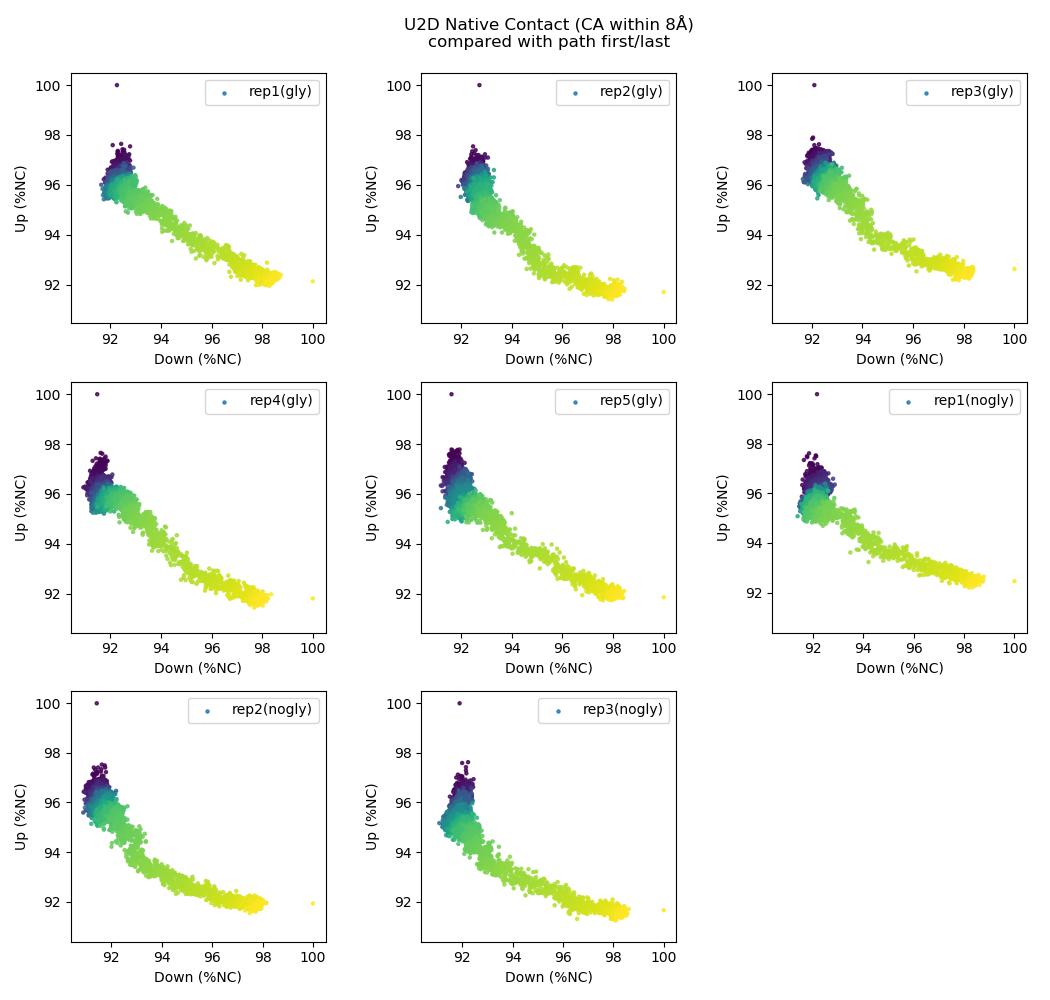

In [132]:
fig1 = plt.figure(figsize=[10.5, 10])
ax = [0, 0, 0, 0, 0, 0, 0, 0]

labels = ['rep1(gly)', 'rep2(gly)', 'rep3(gly)', 'rep4(gly)', 'rep5(gly)', 'rep1(nogly)', 'rep2(nogly)',
          'rep3(nogly)']
ii = 0
temp3 = np.max([np.max(x) for x in contactv3_set_gly_u2d[2:]])
temp4 = np.min([np.min(x) for x in contactv3_set_gly_u2d[2:]])
for item in contactv3_set_gly_u2d[2:]:
    ax[ii] = fig1.add_subplot(3,3,ii+1)
    plt.scatter(item[:,0]*100, item[:,1]*100, label=labels[ii], c=range(len(item[:,1])), s=5, alpha=0.8)
    plt.xlim(temp4*100-0.5, temp3*100+0.5)
    plt.ylim(temp4*100-0.5, temp3*100+0.5)
    plt.legend(loc='best')
    plt.xlabel('Down (%NC)')
    plt.ylabel('Up (%NC)')
    ii += 1

ii = 0
temp3 = np.max([np.max(x) for x in contactv3_set_nogly_u2d])
temp4 = np.min([np.min(x) for x in contactv3_set_nogly_u2d])
for item in contactv3_set_nogly_u2d:
    ax[5+ii] = fig1.add_subplot(3, 3, ii+6)
    plt.scatter(item[:,0]*100, item[:,1]*100, label=labels[ii+5], c=range(len(item[:,1])), s=5, alpha=0.8)
    plt.xlim(temp4*100-0.5, temp3*100+0.5)
    plt.ylim(temp4*100-0.5, temp3*100+0.5)
    plt.legend(loc='best')
    plt.xlabel('Down (%NC)')
    plt.ylabel('Up (%NC)')
    ii += 1

ax[1].set_title('U2D Native Contact (CA within 8Å)\ncompared with path first/last\n')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


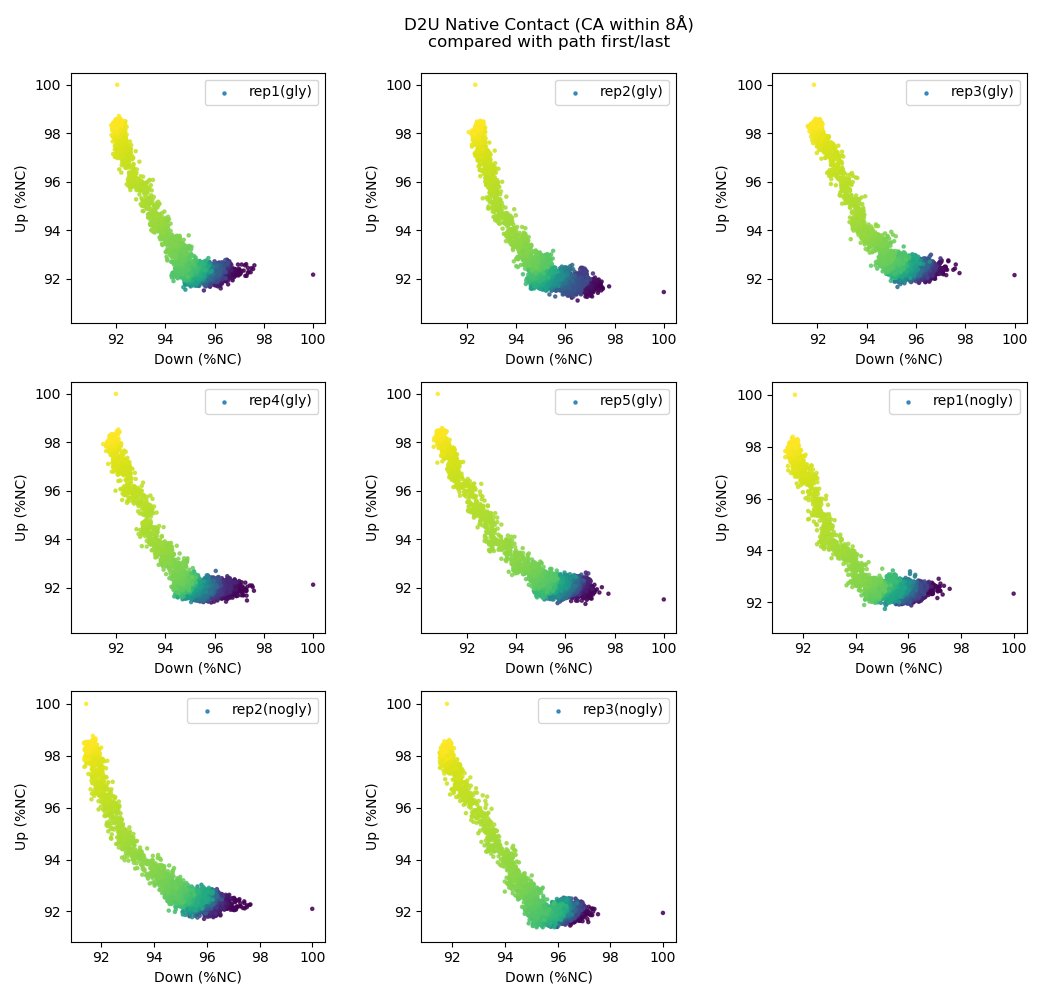

In [134]:
fig = plt.figure(figsize=[10.5, 10])
ax = [0, 0, 0, 0, 0, 0, 0, 0]

labels = ['rep1(gly)', 'rep2(gly)', 'rep3(gly)', 'rep4(gly)', 'rep5(gly)', 'rep1(nogly)', 'rep2(nogly)',
          'rep3(nogly)']
ii = 0
temp3 = np.max([np.max(x) for x in contactv3_set_gly_d2u])
temp4 = np.min([np.min(x) for x in contactv3_set_gly_d2u])
for item in contactv3_set_gly_d2u:
    ax[ii] = fig.add_subplot(3,3,ii+1)
    plt.scatter(item[:,0]*100, item[:,1]*100, label=labels[ii], c=range(len(item[:,1])), s=5, alpha=0.8)
    plt.xlim(temp4*100-0.5, temp3*100+0.5)
    plt.ylim(temp4*100-0.5, temp3*100+0.5)
    plt.legend(loc='best')
    plt.xlabel('Down (%NC)')
    plt.ylabel('Up (%NC)')
    ii += 1

ii = 0
temp3 = np.max([np.max(x) for x in contactv3_set_nogly_d2u])
temp4 = np.min([np.min(x) for x in contactv3_set_nogly_d2u])
for item in contactv3_set_nogly_d2u:
    ax[5+ii] = fig.add_subplot(3, 3, ii+6)
    plt.scatter(item[:,0]*100, item[:,1]*100, label=labels[ii+5], c=range(len(item[:,1])), s=5, alpha=0.8)
    plt.xlim(temp4*100-0.5, temp3*100+0.5)
    plt.ylim(temp4*100-0.5, temp3*100+0.5)
    plt.legend(loc='best')
    plt.xlabel('Down (%NC)')
    plt.ylabel('Up (%NC)')
    ii += 1

ax[1].set_title('D2U Native Contact (CA within 8Å)\ncompared with path first/last\n')

plt.tight_layout()
plt.show()

## Sum of gly x5

In [19]:
upcolors = np.arange(len(contactv1_set_free[0][1:,1]))/len(contactv1_set_free[0][1:,1])
upcolors = [(ii*0.275, ii*0.51, ii*0.706) for ii in upcolors]
cmap = mpl.colors.ListedColormap(upcolors)

downcolors = np.arange(len(contactv1_set_free[1][1:,1]))/len(contactv1_set_free[1][1:,1])
downcolors = [(ii*255/255, ii*165/255, 0) for ii in downcolors]
cmap2 = mpl.colors.ListedColormap(downcolors)

<IPython.core.display.Javascript object>


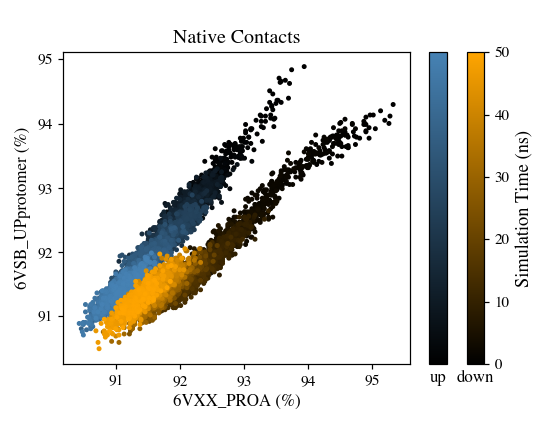

In [20]:
fig = plt.figure(figsize=[5,4])
ax = fig.add_subplot(111, aspect=1)

ax.scatter(contactv1_set_free[0][1:,0]*100, contactv1_set_free[0][1:,1]*100, s=5, alpha=1, 
            color=upcolors, label='up')
ax.scatter(contactv1_set_free[1][1:,0]*100, contactv1_set_free[1][1:,1]*100, s=5, alpha=1, 
            color=downcolors, label='down')
plt.title('Native Contacts', fontsize=13)
plt.xlabel('6VXX_PROA (%)', fontsize=11)
plt.ylabel('6VSB_UPprotomer (%)', fontsize=11)

norm = mpl.colors.Normalize(vmin=0, vmax=50)
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.ax.set_yticklabels([], fontsize=10)
cbar.ax.tick_params(size=0)
# cbar.set_label('   up  down', labelpad=0, x=0, y=-.02, rotation=0, fontsize=11)
cbar.ax.set_xlabel('up', fontsize = 11)

cax2 = divider.append_axes("right", size="5%", pad=0.18)
cbar2 = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap2), cax=cax2)
cbar2.ax.set_yticklabels([0, 10, 20, 30, 40, 50], fontsize=10)
cbar2.ax.set_ylabel('Simulation Time (ns)', fontsize = 12, weight="bold")
cbar2.ax.set_xlabel('down', fontsize = 11)

plt.tight_layout()
plt.show()

plt.savefig('ReportPlots/NCAPlot/NCfree.png', dpi=300)

In [219]:
contactv1_set_free[0][1:,0][0], contactv1_set_free[0][1:,1][0]

(0.9354680607743833, 0.9470829909613805)

In [220]:
contactv1_set_free[1][1:,0][0], contactv1_set_free[1][1:,1][0]

(0.9526221205685346, 0.9400164338537387)

In [198]:
temp3 = np.max([np.max(x) for x in contactv2_set_gly_u2d[2:]])
temp4 = np.min([np.min(x) for x in contactv2_set_gly_u2d[2:]])
temp3, temp4

(0.9850024995834028, 0.9060469765117442)

<IPython.core.display.Javascript object>


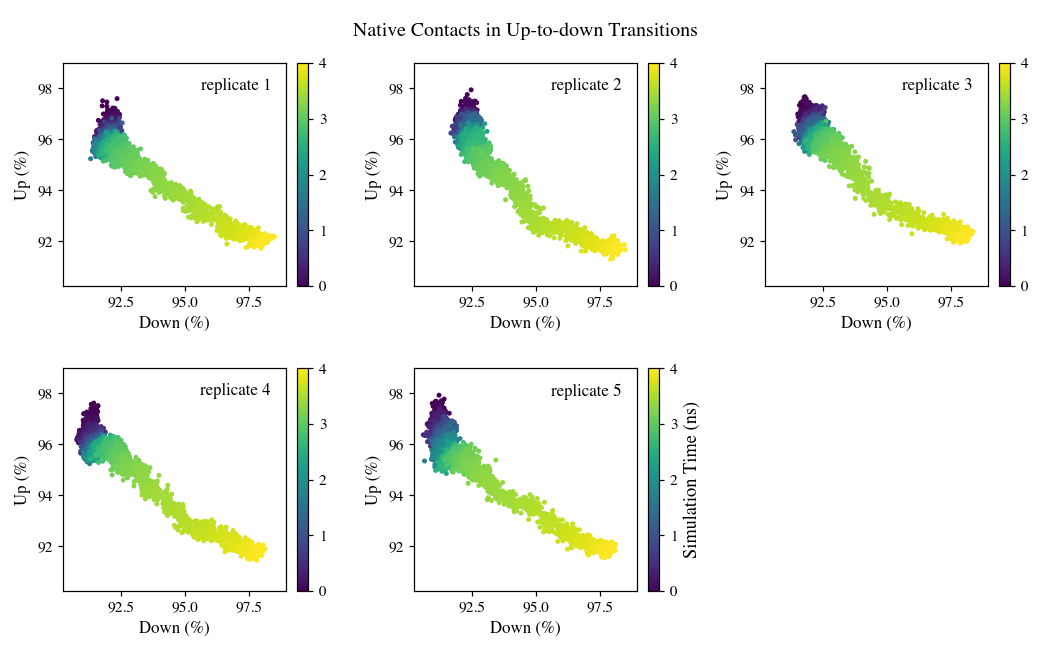

In [21]:
fig1 = plt.figure(figsize=[9.5,6])
ax = [0, 0, 0, 0, 0]

ii = 0
for item in contactv2_set_gly_u2d[2:]:
    ax[ii] = fig1.add_subplot(2,3,ii+1, aspect=1)
    sc = plt.scatter(item[:,0]*100, item[:,1]*100, label=f"replicate {ii+1}", c=range(len(item[:,1])), s=5, alpha=1)
    plt.xlim(0.905*100-0.25, 0.987*100+0.25)
    plt.ylim(0.905*100-0.25, 0.987*100+0.25)
    plt.legend(loc='best', markerscale=0, frameon=False, fontsize=11)
    plt.xlabel('Down (%)', fontsize=11)
    plt.ylabel('Up (%)', fontsize=11)
    divider = make_axes_locatable(ax[ii])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(sc,cax=cax)
    cbar.set_ticks([0, 1000, 2000, 3000, 3999])
    cbar.ax.set_yticklabels([0, 1, 2, 3, 4], fontsize=10)
    ii += 1

ax[1].set_title("Native Contacts in Up-to-down Transitions", fontsize=13, pad=18)
cbar.ax.set_ylabel('Simulation Time (ns)', fontsize = 12, weight="bold")

plt.tight_layout()
plt.show()

plt.savefig('ReportPlots/NCAPlot/NCu2d.png', dpi=300)

In [200]:
temp3 = np.max([np.max(x) for x in contactv2_set_gly_d2u])
temp4 = np.min([np.min(x) for x in contactv2_set_gly_d2u])
temp3, temp4

(0.9869761228919686, 0.9092120606363485)

<IPython.core.display.Javascript object>


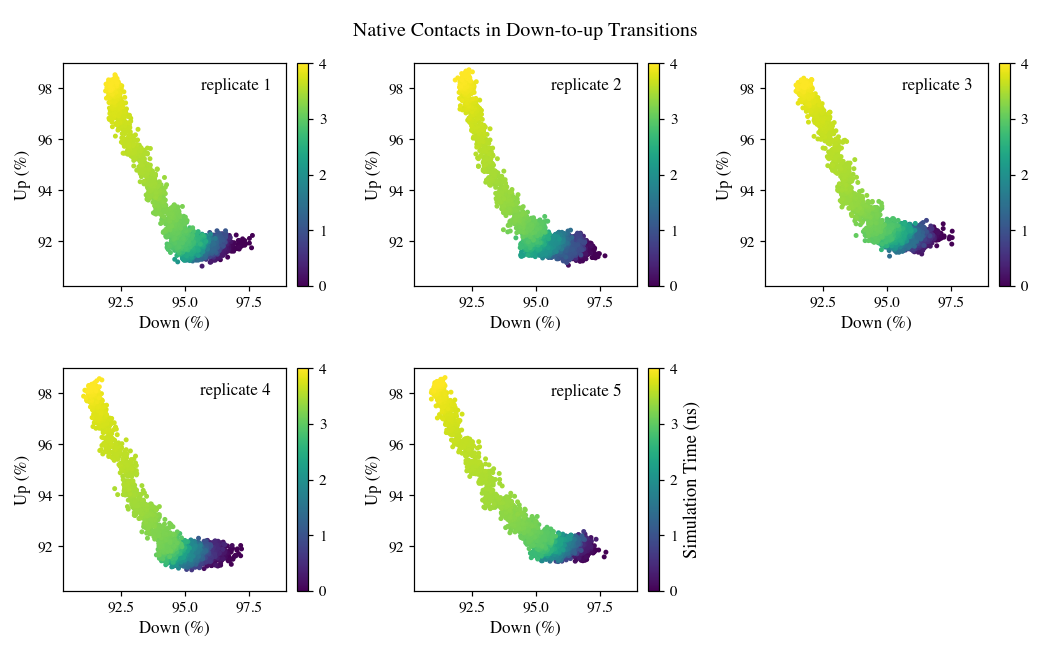

In [22]:
fig1 = plt.figure(figsize=[9.5,6])
ax = [0, 0, 0, 0, 0]

ii = 0
for item in contactv2_set_gly_d2u:
    ax[ii] = fig1.add_subplot(2,3,ii+1, aspect=1)
    sc = plt.scatter(item[:,0]*100, item[:,1]*100, label=f"replicate {ii+1}", c=range(len(item[:,1])), s=5, alpha=1)
    plt.xlim(0.905*100-0.25, 0.987*100+0.25)
    plt.ylim(0.905*100-0.25, 0.987*100+0.25)
    plt.legend(loc='best', markerscale=0, frameon=False, fontsize=11)
    plt.xlabel('Down (%)', fontsize=11)
    plt.ylabel('Up (%)', fontsize=11)
    divider = make_axes_locatable(ax[ii])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(sc,cax=cax)
    cbar.set_ticks([0, 1000, 2000, 3000, 3999])
    cbar.ax.set_yticklabels([0, 1, 2, 3, 4], fontsize=10)
    ii += 1

ax[1].set_title("Native Contacts in Down-to-up Transitions", fontsize=13, pad=18)
cbar.ax.set_ylabel('Simulation Time (ns)', fontsize = 12, weight="bold")

plt.tight_layout()
plt.show()

plt.savefig('ReportPlots/NCAPlot/NCd2u.png', dpi=300)

In [202]:
temp3 = np.max([np.max(x) for x in contactv3_set_gly_u2d[2:]])
temp4 = np.min([np.min(x) for x in contactv3_set_gly_u2d[2:]])
temp3, temp4

(1.0, 0.9093781177253076)

<IPython.core.display.Javascript object>


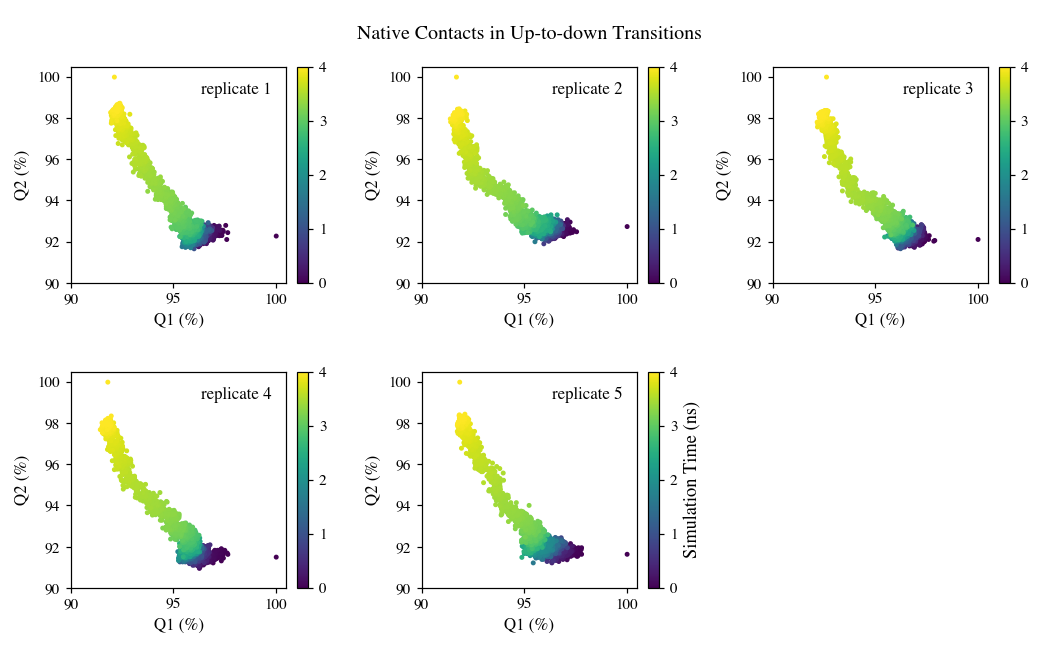

In [182]:
fig1 = plt.figure(figsize=[9.5,6])
ax = [0, 0, 0, 0, 0]

ii = 0
for item in contactv3_set_gly_u2d[2:]:
    ax[ii] = fig1.add_subplot(2,3,ii+1, aspect=1)
    sc = plt.scatter(item[:,1]*100, item[:,0]*100, label=f"replicate {ii+1}", c=range(len(item[:,1])), s=5, alpha=1)
    plt.ylim(0.905*100-0.5, 100+0.5)
    plt.xlim(0.905*100-0.5, 100+0.5)
    
    plt.legend(loc='best', markerscale=0, frameon=False, fontsize=11)
    plt.xlabel('Q1 (%)', fontsize=11)
    plt.ylabel('Q2 (%)', fontsize=11)
    divider = make_axes_locatable(ax[ii])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(sc,cax=cax)
    cbar.set_ticks([0, 1000, 2000, 3000, 3999])
    cbar.ax.set_yticklabels([0, 1, 2, 3, 4], fontsize=10)
    ii += 1

ax[1].set_title("Native Contacts in Up-to-down Transitions", fontsize=13, pad=18)
cbar.ax.set_ylabel('Simulation Time (ns)', fontsize = 12, weight="bold")

plt.tight_layout()
plt.show()

plt.savefig('ReportPlots/NCAPlot/NCu2d_self.png', dpi=300)

In [204]:
temp3 = np.max([np.max(x) for x in contactv3_set_gly_d2u])
temp4 = np.min([np.min(x) for x in contactv3_set_gly_d2u])
temp3, temp4

(1.0, 0.906562291805463)

<IPython.core.display.Javascript object>


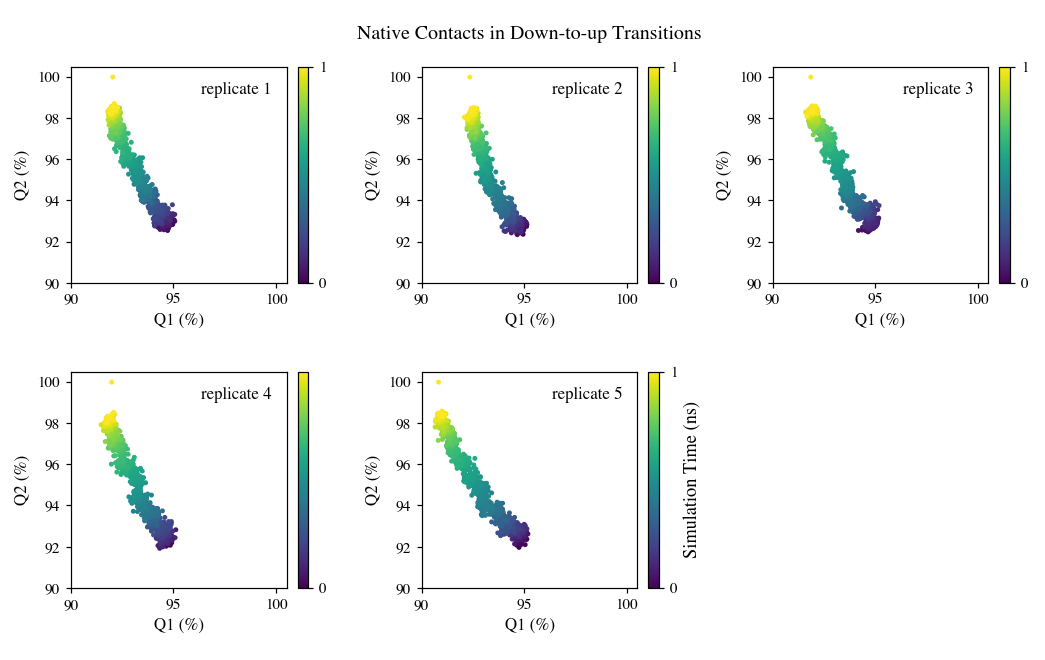

In [269]:
fig1 = plt.figure(figsize=[9.5,6])
ax = [0, 0, 0, 0, 0]

ii = 0
for item in contactv3_set_gly_d2u:
    ax[ii] = fig1.add_subplot(2,3,ii+1, aspect=1)
    sc = plt.scatter(item[:,0][3000:]*100, item[:,1][3000:]*100, label=f"replicate {ii+1}", 
                     c=range(len(item[:,1][3000:])), s=5, alpha=1)
    plt.xlim(0.905*100-0.5, 100+0.5)
    plt.ylim(0.905*100-0.5, 100+0.5)
    
    plt.legend(loc='best', markerscale=0, frameon=False, fontsize=11)
    plt.xlabel('Q1 (%)', fontsize=11)
    plt.ylabel('Q2 (%)', fontsize=11)
    divider = make_axes_locatable(ax[ii])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(sc,cax=cax)
    cbar.set_ticks([0, 1000, 2000, 3000, 3999])
    cbar.ax.set_yticklabels([0, 1, 2, 3, 4], fontsize=10)
    ii += 1

ax[1].set_title("Native Contacts in Down-to-up Transitions", fontsize=13, pad=18)
cbar.ax.set_ylabel('Simulation Time (ns)', fontsize = 12, weight="bold")

plt.tight_layout()
plt.show()

# plt.savefig('ReportPlots/NCAPlot/NCd2u_self.png', dpi=300)

Published d2u path

In [22]:
with open('saved_pkl/v3_dic_NCA_self_s1-amaro.pkl', 'rb') as f:
    result_new = pickle.load(f)

In [221]:
np.shape(result_new[:,2])

(1725,)

<IPython.core.display.Javascript object>


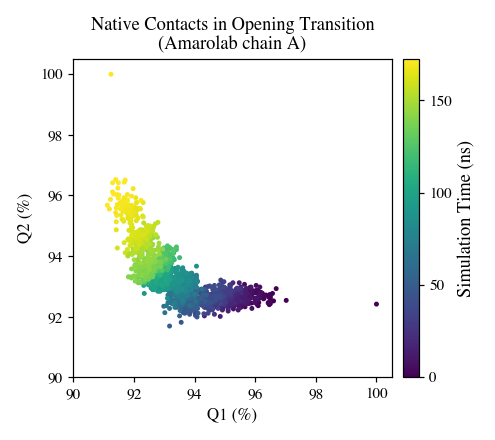

In [197]:
fig = plt.figure(figsize=[4.5, 4])
ax = fig.add_subplot(111, aspect=1)
sc=plt.scatter(result_new[:, 1]*100, result_new[:, 2]*100, c=range(len(result_new[:, 1])),
            s=5, alpha=1., label='chainA')

# item = contactv3_set_gly_d2u[-1]
# plt.scatter(item[:,0]*100, item[:,1]*100, label=f"replicate {ii+1}", c=range(len(item[:,1])), s=5, alpha=1)

# plt.legend(loc='best', markerscale=0, frameon=False, fontsize=11)
plt.xlabel('Q1 (%)', fontsize=11)
plt.ylabel('Q2 (%)', fontsize=11)
plt.title('Native Contacts in Opening Transition\n(Amarolab chain A)', fontsize=12)
plt.xlim(90, 100.5)
plt.ylim(90, 100.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sc,cax=cax)
cbar.set_ticks([0, 500, 1000, 1500])
cbar.ax.set_yticklabels([0, 50, 100, 150], fontsize=10)
cbar.ax.set_ylabel('Simulation Time (ns)', fontsize = 12, weight="bold")

plt.tight_layout()
plt.show()

plt.savefig('ReportPlots/NCAPlot/NCd2u_amarolab.png', dpi=300)

In [269]:
len(colors2)

2001

<IPython.core.display.Javascript object>


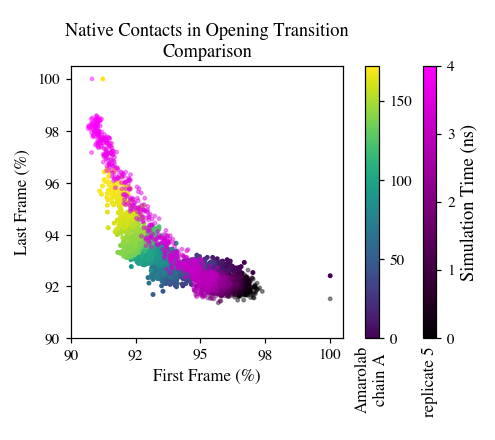

In [196]:
fig = plt.figure(figsize=[4.5, 4])
ax = fig.add_subplot(111, aspect=1)

# colors1 = np.arange(len(result_new[:, 1]))/len(result_new[:, 1])
# colors1 = [(ii*0.275, ii*0.51, ii*0.706) for ii in colors1]
# colors1 = [(ii, ii, ii) for ii in colors1]
# colors1 = np.arange(len(result_new[:, 1]))
# cmap = mpl.colors.ListedColormap(colors1)

sc=plt.scatter(result_new[:, 1]*100, result_new[:, 2]*100, c=range(len(result_new[:, 1])),
            s=5, alpha=1., label='Amarolab')

item = contactv3_set_gly_d2u[-1]
colors2 = np.arange(len(item[:,1][::2]))/len(item[:,1][::2])
colors2 = [(ii*1, ii*0, ii*1) for ii in colors2]
cmap2 = mpl.colors.ListedColormap(colors2)
plt.scatter(item[:,0][::2]*100, item[:,1][::2]*100, label=f"replicate {ii+1}", c=colors2, s=5, alpha=0.4)
from matplotlib.ticker import FormatStrFormatter
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.xlim(90, 100.5)
plt.ylim(90, 100.5)
plt.xlabel('First Frame (%)', fontsize=11)
plt.ylabel('Last Frame (%)', fontsize=11)
plt.title('Native Contacts in Opening Transition\nComparison', fontsize=12)


divider = make_axes_locatable(ax)

norm = mpl.colors.Normalize(vmin=0, vmax=1725)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(sc,cax=cax, norm=norm)
cbar.set_ticks([0, 500, 1000, 1500])
cbar.set_ticklabels([0, 50, 100, 150])
cbar.ax.set_xlabel('Amarolab\nchain A', labelpad=5, fontsize = 11, rotation=90)

norm2 = mpl.colors.Normalize(vmin=0, vmax=4)
cax2 = divider.append_axes("right", size="5%", pad=0.4)
cbar2 = plt.colorbar(cm.ScalarMappable(norm=norm2, cmap=cmap2), cax=cax2)
cbar2.set_ticks([0, 1, 2, 3, 4])
cbar2.set_ticklabels([0, 1, 2, 3, 4])
cbar2.ax.set_ylabel('Simulation Time (ns)', fontsize = 12, weight="bold")
cbar2.ax.set_xlabel('replicate 5', labelpad=5, fontsize = 11, rotation=90)

plt.tight_layout()
plt.show()

# plt.savefig('ReportPlots/NCAPlot/NCd2u_compare.png', dpi=300)